In [1]:
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')
from itertools import product

import numpy as np
import pandas as pd

import seaborn as sns
# import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

import scipy
import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
import lightgbm
from lightgbm import LGBMRegressor

# !conda install -y -c districtdatalabs yellowbrick
import yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

# !conda install -y -c conda-forge mlxtend
import mlxtend
from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

RANDOM_STATE=42
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())

print ("%-20s %s"% ("numpy", np.__version__))
print ("%-20s %s"% ("pandas", pd.__version__))
print ("%-20s %s"% ("seaborn", sns.__version__))
print ("%-20s %s"% ("matplotlib", matplotlib.__version__))
print ("%-20s %s"% ("sklearn", sklearn.__version__))
print ("%-20s %s"% ("scipy", scipy.__version__))
print ("%-20s %s"% ("xgboost", xgboost.__version__))
print ("%-20s %s"% ("lightgbm", lightgbm.__version__))
#print ("%-20s %s"% ("yellowbrick", yellowbrick.__version__))
#print ("%-20s %s"% ("mlxtend", mlxtend.__version__))


2020-10-13 17:57:34.444997
numpy                1.19.1
pandas               1.1.3
seaborn              0.11.0
matplotlib           3.3.1
sklearn              0.23.2
scipy                1.5.0
xgboost              1.2.0
lightgbm             2.3.0


### 1. Import

In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial exploration

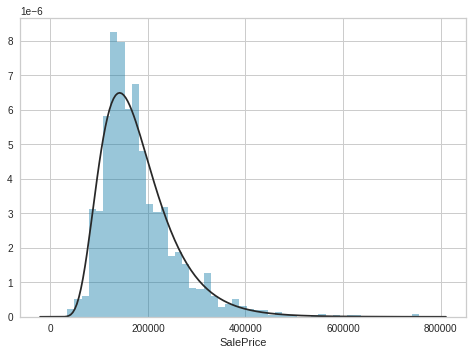

In [3]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


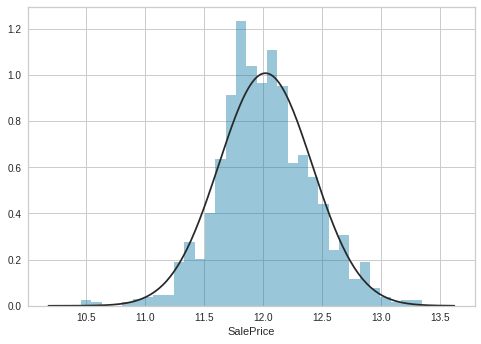

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


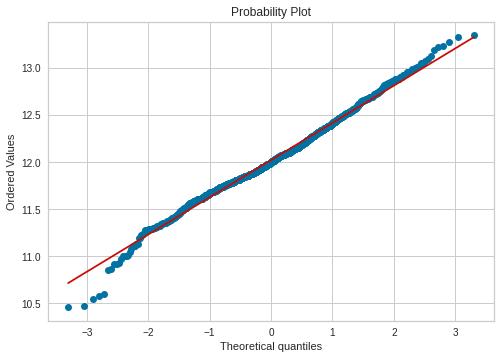

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [6]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)


['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

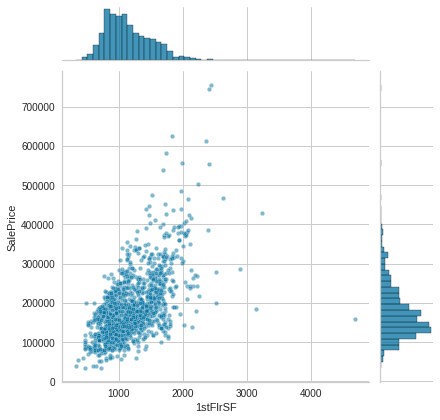

In [7]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  #hue=colorby,
                  #palette=colordict
                 )

do_refresh()


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

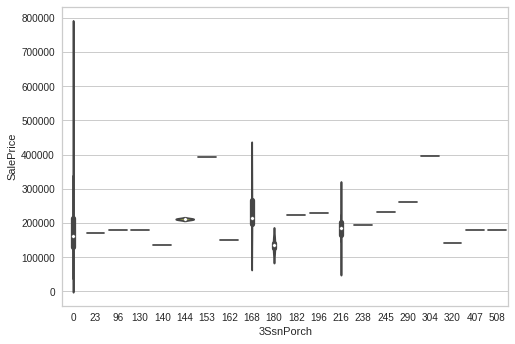

In [8]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [9]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [10]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)


(2919, 80)


### 2. Scrub

In [11]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [12]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)


(2919, 80)
23
23
34
(2919, 80)


In [13]:
df_raw.head()


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,IR1,AllPub,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


In [14]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [15]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

qdict = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4,
    np.nan : 2
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())
    

ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [16]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())


Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [17]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())


Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [18]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [19]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [20]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())


Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [21]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [22]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [23]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [24]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [25]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [26]:
print(df['CentralAir'].value_counts())
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)
print(df['CentralAir'].value_counts())


Y    2719
N     196
Name: CentralAir, dtype: int64
1    2719
0     196
Name: CentralAir, dtype: int64


In [27]:
df.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,1,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,0,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,6,8,2,2,3,2,4,5,1,4,4,2,4,2,2,2,2,2,NaN,0,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,7,5,3,2,3,2,2,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,5,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,1,Detchd,NaN,WD,Abnorml,1,AllPub,0,7,5,2,2,2,3,1,5,1,3,4,3,4,3,1,2,2,2,NaN,0,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,8,5,3,2,3,2,3,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


#### Impute / fill NAs

In [28]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

zlist = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
         '2ndFlrSF','LowQualFinSF',
         'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
         'Fireplaces','GarageCars','GarageArea',
         'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
         'PoolArea','MiscVal']
        
for col in zlist:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
GarageYrBlt
GarageType


In [29]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()
    

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
B

0.0       242
384.0      19
728.0      14
672.0      13
600.0      12
         ... 
532.0       1
1503.0      1
445.0       1
185.0       1
1686.0      1
Name: BsmtUnfSF, Length: 1134, dtype: int64

TotalBsmtSF
0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
1866.0     1
1641.0     1
961.0      1
1949.0     1
1905.0     1
Name: TotalBsmtSF, Length: 1054, dtype: int64

1stFlrSF
864     46
1040    28
912     19
960     18
848     18
        ..
2084     1
2076     1
2064     1
2048     1
2053     1
Name: 1stFlrSF, Length: 1079, dtype: int64

2ndFlrSF
0       1668
546       23
728       18
504       17
672       13
        ... 
1036       1
1038       1
1042       1
1048       1
1721       1
Name: 2ndFlrSF, Length: 631, dtype: int64

LowQualFinSF
0       2875
80         4
205        2
360        2
390        1
384        1
362        1
312        1
234        1
232        1
420        1
156        1
144        1
140        1
120        1
114        1
108      

In [30]:
df.loc[df['MSSubClass'] == 150]

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2819,150,RL,Pave,NaN,HLS,Inside,ClearCr,Norm,Norm,Twnhs,4,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,1,Basment,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,2,6,1,2,4,3,4,2,3,3,2,2,NaN,0,1980,1981,1,0,2,1,2,1,7,0,1980,1,4,2006,NaN,1700,0.0,397.0,0.0,33.0,430.0,880,680,140,1700,450.0,188,36,0,0,200,0,0,NaN


In [31]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

,MSSubClass,SalePrice
1,30,95829.724638
14,180,102300.000000
3,45,108591.666667
15,190,129613.333333
10,90,133541.076923
13,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


,MSSubClass,SalePrice
12,150,0
2,40,4
14,180,10
3,45,12
7,75,16
9,85,20
15,190,30
10,90,52
8,80,58
6,70,60


In [32]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [33]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [34]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)


Alley missing 2717
Grvl    120
Pave     78
Name: Alley, dtype: int64
Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
MiscFeature missing 2810
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw 

In [35]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')


In [36]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Grvl': 0, 'Pave': 1, 'None': 2, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'

#### Roll up rare categorical values

In [37]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [38]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


LandContour
0     115
1    2620
2      60
3     120
Name: LandContour, dtype: int64
LotConfig
0    2132
1     508
2      85
3      14
4     176
Name: LotConfig, dtype: int64
Neighborhood
0      37
1      93
2      30
3     108
4     192
5     239
6     151
7      10
8      48
9      23
10    443
11    114
12    125
13    131
14    165
15     28
16    267
17    103
18     44
19    182
20     24
21     72
22     51
23     69
24    166
Name: Neighborhood, dtype: int64
Condition1
0      92
1      28
2     163
3    2509
4      50
5       6
6       9
7      38
8      20
Name: Condition1, dtype: int64
Condition2
0       2
1       5
2      13
3       1
4    2886
5       1
6       4
7       3
Name: Condition2, dtype: int64
0 => 1
3 => 4
5 => 6
7 => 6
BldgType
0      62
1     109
2      96
3     227
4    2421
Name: BldgType, dtype: int64
RoofStyle
0      22
1    2309
2      11
3      20
4     548
5       5
Name: RoofStyle, dtype: int64
RoofMatl
0       1
1    2874
2       1
3      23
4       9
5

#### Engineer features

In [39]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] >=4, 'TotalBath'] = 4
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] >= 1, 'BsmtBath'] = 1

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['PreWarYearBuilt'] = df['YearBuilt'].apply(lambda x: 68-x if x < 68 else 0) 
df['RecentYearBuilt'] = df['YearBuilt'].apply(lambda x: 12-x if x < 12 else 0) 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 3, 'GarageCars'] = 3
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] >= 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5
# merge unpaved, partial paved
df.loc[df['PavedDrive']==1,'PavedDrive'] = 0

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF'] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
#df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
#df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

#df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
#df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         

In [40]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


,monthnum,YrSold,MoSold
0,0,2006,1
1,1,2006,2
2,2,2006,3
3,3,2006,4
4,4,2006,5


,monthnum,YrSold,MoSold
50,50,2010,3
51,51,2010,4
52,52,2010,5
53,53,2010,6
54,54,2010,7


(2915, 114)
(2915, 115)


#### Transform (logs, squares)

In [41]:
def mytransform(df, transform_list, transform_func, transform_prefix, replace=False):
    
    for col in transform_list:
        print(col)
        if replace:
            df[col] = df[col].apply(transform_func)
            df.rename(columns={col : transform_prefix + col}, inplace=True)
        else:
            newcol = transform_prefix + col
            df[newcol] = df[col].apply(transform_func)

    return df
            


In [42]:
transform_log = ['YearBuilt', 'GarageYrBlt', 'LotArea', 'LowQualFinSF', 'GrLivArea', 
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 
                 'TotalFinSF', 'RecentYearBuilt', 'LivAreaRatio', 'BedRatio', 'GarageRatio', 
                 'BathRatio', 'LotRatio', 'FireBathRatio', 'TotalSF x OverallQual x OverallCond', 
                 'TotalSF x OverallQual', 'TotalSF x OverallCond', 'AvgBltRemod x OverallCond', 
                 'AvgBltRemod x TotalFinSF', 'OverallCond x AvgBltRemod']

df = mytransform(df, transform_log, lambda x: np.log1p(x), 'log_', replace=False)


YearBuilt
GarageYrBlt
LotArea
LowQualFinSF
GrLivArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
MiscVal
TotalFinSF
RecentYearBuilt
LivAreaRatio
BedRatio
GarageRatio
BathRatio
LotRatio
FireBathRatio
TotalSF x OverallQual x OverallCond
TotalSF x OverallQual
TotalSF x OverallCond
AvgBltRemod x OverallCond
AvgBltRemod x TotalFinSF
OverallCond x AvgBltRemod


In [43]:
# we test variables further below to see if log or square has higher correlation with response and transform accordingly

transform_square =['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 
                   'PreWarYearBuilt', 'Functional x OverallQual', 'BsmtFinSF x BsmtQual', 
                   'BsmtFinSF x BsmtBath',]

df = mytransform(df, transform_square, lambda x: x **2, 'sq_', replace=False)



BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
2ndFlrSF
BsmtFinSF
PreWarYearBuilt
Functional x OverallQual
BsmtFinSF x BsmtQual
BsmtFinSF x BsmtBath


In [44]:
list(df.columns)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'MoSold',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'G

#### Fix highly skewed predictors

In [45]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Final Review and Final Setup

In [46]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [47]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
#            'MiscVal',
#            'MiscFeature',
#            'PoolArea',
            'Street', 
            'FireplaceQu',
#            'LandContour'
           ]

#df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 147)


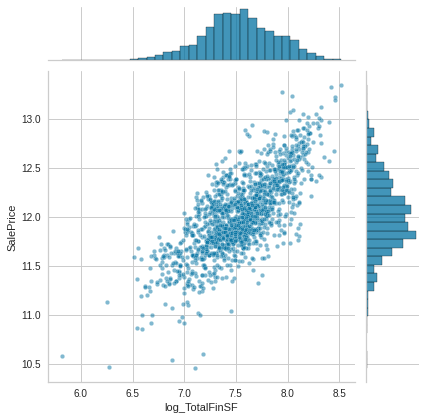

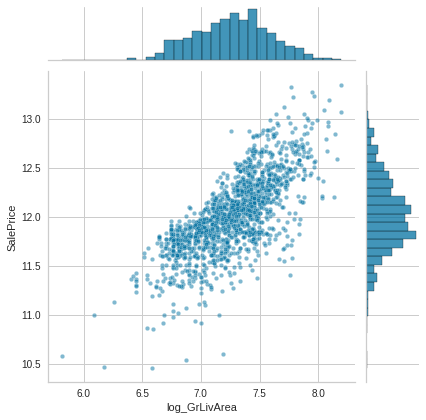

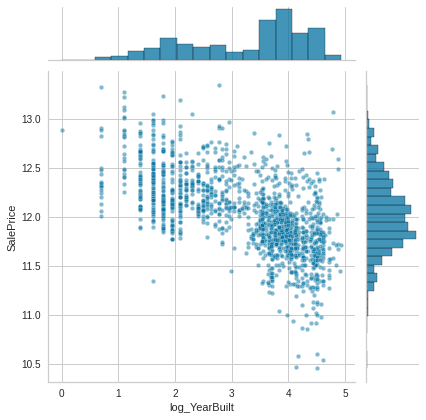

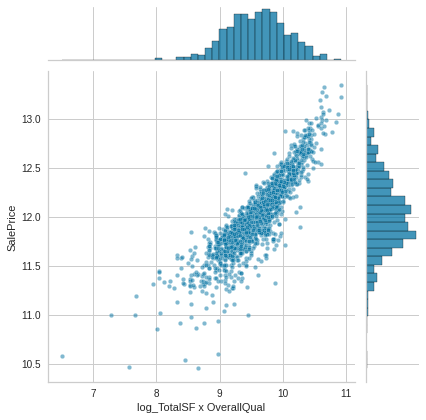

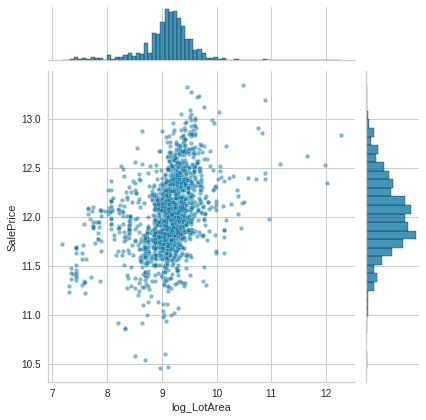

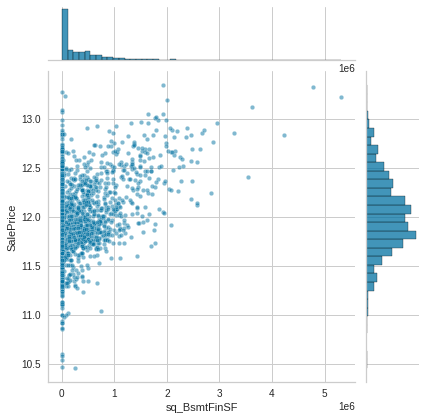

In [48]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['log_TotalFinSF','log_GrLivArea','log_YearBuilt','log_TotalSF x OverallQual','log_LotArea','sq_BsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
#                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    

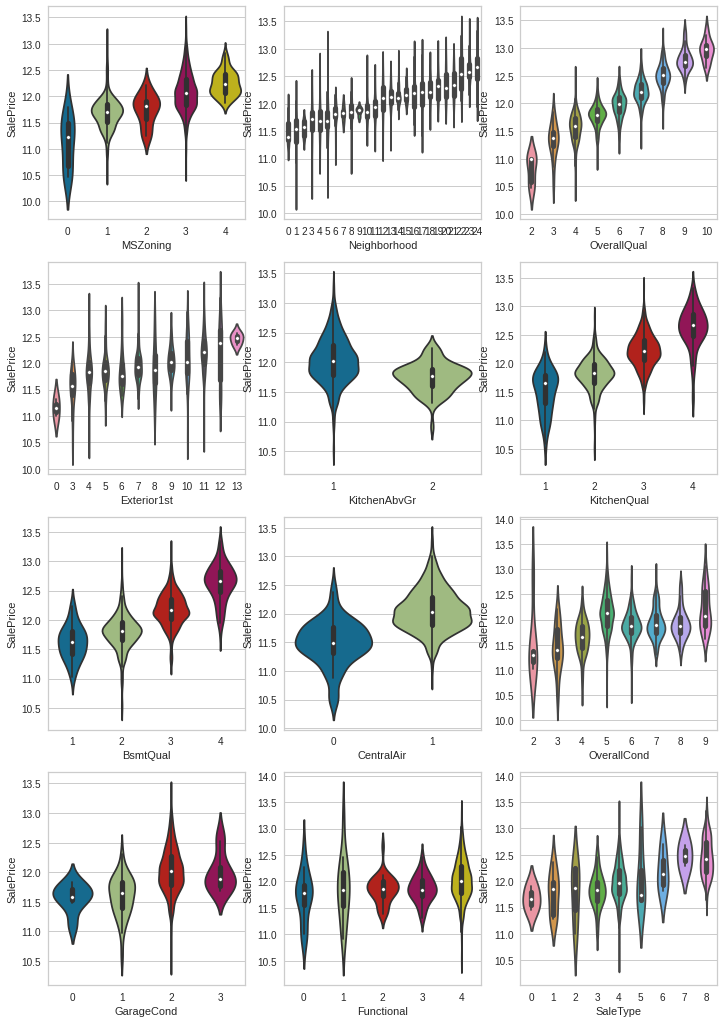

In [49]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [50]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireBathRatio', 'FireplaceQu', 'FireplaceQu x Fireplaces', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'Functional x OverallQual', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageQual x GarageCond x GarageCars', 'GarageRatio', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HeatingQC x Heating', 'HouseStyle', 'KitchenAbvGr', 'KitchenAbvGr x KitchenQual', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RecentYearBuilt', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'TotalBath', 'Utilities', 'has2ndfloor'

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', '3SsnPorch', 'AvgBltRemod', 'AvgBltRemod x …

Dropdown(description='Color by:', index=51, options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCon…

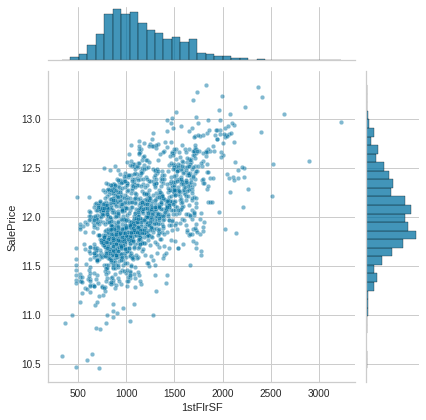

In [51]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposu…

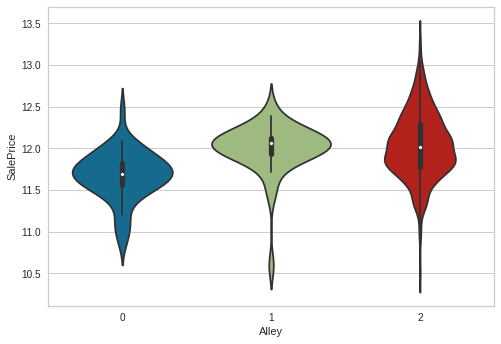

In [52]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [53]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
logtransformlist = []
sqtransformlist = []

for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    whichbiggest = np.argmax(np.array([abs(log), abs(linear), abs(square)]))
    print(col, 'log', log, 'linear', linear, 'square', square, whichbiggest)

    cardinality = len(df[col].value_counts())
    if cardinality > 12:
        if whichbiggest == 2:
            sqtransformlist.append(col)
        if whichbiggest == 0:
            logtransformlist.append(col)   
        
print('logs', logtransformlist)
print('squares', sqtransformlist)

MSSubClass log -0.00047989077349514165 linear -0.045144516906380425 square -0.09328233312170457 2
MSZoning log 0.4175327514848593 linear 0.4127975685290464 square 0.39689740866463447 0
Street log 0.05759485677712942 linear 0.05759485677712976 square 0.05759485677712976 1
Alley log 0.16242653532499027 linear 0.1575460682460869 square 0.14547854440633073 0
LandContour log 0.16278764070540458 linear 0.15709534886644316 square 0.1340251359108606 0
LotConfig log 0.12785450847566457 linear 0.144245719168227 square 0.15374067854700793 2
Neighborhood log 0.6886270727823947 linear 0.7420311981460954 square 0.7282914789507744 1
Condition1 log 0.18505776922193265 linear 0.18380549468895435 square 0.14073313864977874 0
Condition2 log 0.10212307960484673 linear 0.10726550305334899 square 0.10860889036903426 2
BldgType log 0.18116649123563178 linear 0.18315594370218288 square 0.1751113359420227 1
HouseStyle log 0.11447612264187955 linear 0.13935729462582244 square 0.16966228611424955 2
RoofStyle log

TotalSF x OverallQual x Functional log 0.40513686043451613 linear 0.8575586917219975 square 0.7907420240563388 1
AvgBltRemod x Functional x TotalFinSF log -0.1691899888382816 linear -0.2604059475550344 square -0.11858034423388866 1
TotalSF x OverallQual log 0.8852956735269517 linear 0.8832708405722174 square 0.8023493023866501 0
TotalSF x OverallCond log 0.7231243247860634 linear 0.7014960077449588 square 0.6165883590414881 0
TotalFinSF x Functional log 0.33478332694090607 linear 0.7242600148131664 square 0.7073787040749955 1
Functional x OverallQual log 0.4720268009503287 linear 0.7079377892301999 square 0.7687393365451083 2
AvgBltRemod x OverallCond log -0.605018999527189 linear -0.542004623424775 square -0.4100808094254443 0
AvgBltRemod x TotalFinSF log -0.40608085105924313 linear -0.28701310835726973 square -0.13445209922177867 0
OverallCond x AvgBltRemod log -0.605018999527189 linear -0.542004623424775 square -0.4100808094254443 0
BsmtFinSF x BsmtQual log 0.22200314077454672 linea

In [54]:
predictors_simple = [p for p in df.columns if p != response]

In [55]:
# make these strings, forces dummification (could also just specify columns to dummify)
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

dummy_cols = [
    'BldgType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'ExterCond',
    'ExterQual',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
#    'FireplaceQu',
    'Fireplaces',
    'Foundation',
    'Functional',
    'GarageCars',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
#    'GarageQual x GarageCond x GarageCars',
    'Heating',
    'HeatingQC',
    'HouseStyle',
    'KitchenQual',
#    'LandContour',
    'LandSlope',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MoSold',
    'Neighborhood',
    'OverallCond',
    'OverallQual',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
#    'monthnum',
    'BedroomAbvGr',
    'BsmtBath',
#    'FireBathRatio',
    'HalfBath',
#    'MiscFeature',
    'PoolQC',
    'TotalBath',
#    'FireplaceQu x Fireplaces',
#    'GarageRatio',
#    'KitchenAbvGr x KitchenQual',
#    'Functional x OverallQual',
]


for col in dummy_cols:
    cardinality = df[col].value_counts().shape[0]
    #    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
    print(col, cardinality)
#    df[col] = df[col].apply(str)

predictors_nodummies = [p for p in df.columns if p != response and p not in dummy_cols]
print(predictors_nodummies)

tempdf = pd.get_dummies(df[dummy_cols],columns=dummy_cols)
predictors_dummies=list(tempdf.columns)
print()
print(predictors_dummies)
predictors_full = predictors_nodummies + predictors_dummies

df = pd.concat([df, tempdf], axis=1)
df.head()

BldgType 5
BsmtCond 3
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
BsmtQual 4
CentralAir 2
Condition1 9
Condition2 4
Electrical 4
ExterCond 4
ExterQual 4
Exterior1st 12
Exterior2nd 13
Fence 5
Fireplaces 4
Foundation 6
Functional 5
GarageCars 4
GarageCond 4
GarageFinish 4
GarageQual 3
GarageType 7
Heating 4
HeatingQC 4
HouseStyle 8
KitchenQual 4
LandSlope 3
LotConfig 5
LotShape 3
MSSubClass 13
MSZoning 5
MasVnrType 4
MoSold 12
Neighborhood 25
OverallCond 8
OverallQual 9
PavedDrive 2
RoofMatl 4
RoofStyle 6
SaleCondition 6
SaleType 9
BedroomAbvGr 7
BsmtBath 3
HalfBath 3
PoolQC 4
TotalBath 7
['Street', 'Alley', 'LandContour', 'MiscFeature', 'Utilities', 'FireplaceQu', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', '

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,TotalFinSF,TotalSF,BsmtFinSF,PorchSF,TotalBath,BsmtBath,AvgBltRemod,PreWarYearBuilt,RecentYearBuilt,haspool,has2ndfloor,hasfireplace,LivAreaRatio,BedRatio,GarageRatio,BathRatio,LotRatio,FireBathRatio,TotalSF x OverallQual x OverallCond,TotalSF x OverallQual x Functional,AvgBltRemod x Functional x TotalFinSF,TotalSF x OverallQual,TotalSF x OverallCond,TotalFinSF x Functional,Functional x OverallQual,AvgBltRemod x OverallCond,AvgBltRemod x TotalFinSF,OverallCond x AvgBltRemod,BsmtFinSF x BsmtQual,BsmtFinSF x BsmtBath,KitchenAbvGr x KitchenQual,GarageCars x GarageYrBlt,GarageQual x GarageCond x GarageCars,HeatingQC x Heating,FireplaceQu x Fireplaces,monthnum,log_YearBuilt,log_GarageYrBlt,log_LotArea,log_LowQualFinSF,log_GrLivArea,log_WoodDeckSF,log_OpenPorchSF,log_EnclosedPorch,log_3SsnPorch,log_MiscVal,log_TotalFinSF,log_RecentYearBuilt,log_LivAreaRatio,log_BedRatio,log_GarageRatio,log_BathRatio,log_LotRatio,log_FireBathRatio,log_TotalSF x OverallQual x OverallCond,log_TotalSF x OverallQual,log_TotalSF x OverallCond,log_AvgBltRemod x OverallCond,log_AvgBltRemod x TotalFinSF,log_OverallCond x AvgBltRemod,sq_BsmtFinSF1,sq_BsmtFinSF2,sq_BsmtUnfSF,sq_2ndFlrSF,sq_BsmtFinSF,sq_PreWarYearBuilt,sq_Functional x OverallQual,sq_BsmtFinSF x BsmtQual,sq_BsmtFinSF x BsmtBath,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,CentralAir_0,CentralAir_1,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_4,Condition2_6,Electrical_0,Electrical_2,Electrical_3,Electrical_4,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,Exterior1st_0,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior2nd_1,Exterior2nd_2,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,Heating_1,Heating_2,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,KitchenQual_1,KitchenQual_2,KitchenQual_3,Kitch

In [56]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance


['Street',
 'Utilities',
 'PoolQC',
 'PoolArea',
 'haspool',
 'Condition1_5',
 'Condition1_6',
 'Condition2_1',
 'Condition2_2',
 'Condition2_6',
 'Electrical_0',
 'ExterCond_4',
 'Exterior1st_0',
 'Exterior1st_13',
 'Exterior2nd_7',
 'Exterior2nd_12',
 'Fence_1',
 'Fireplaces_3',
 'Foundation_3',
 'Foundation_4',
 'GarageCond_0',
 'GarageType_1',
 'Heating_1',
 'Heating_2',
 'HouseStyle_7',
 'LandSlope_2',
 'LotConfig_3',
 'Neighborhood_7',
 'OverallCond_2',
 'OverallQual_2',
 'RoofMatl_4',
 'RoofMatl_6',
 'RoofStyle_2',
 'RoofStyle_5',
 'SaleCondition_0',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'BedroomAbvGr_0',
 'PoolQC_0',
 'PoolQC_1',
 'PoolQC_2',
 'PoolQC_3']

In [57]:
# drop only >= 2911 identical
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)
predictors_full = [p for p in predictors_full if p not in dropcols]
predictors_simple = [p for p in predictors_simple if p not in dropcols]

Utilities 2914
Exterior1st_13 2912
PoolQC_1 2913
PoolQC_2 2912
PoolQC_3 2912


In [58]:
df[predictors_full].shape

(2915, 377)

In [59]:
# bottom least important features
# lowimplasso = {'sq_BsmtQual', 'log_BsmtUnfSF', 'log_ScreenPorch', 'PoolArea',
#        'LowQualFinSF', 'PavedDrive', '3SsnPorch', 'RoofStyle', 'MoSold',
#        'ScreenPorch', 'Fence', 'sq_GarageQual', 'LotRatio', 'GarageCond',
#        'EnclosedPorch', 'BsmtFinSF2', 'LotFrontage', 'MiscVal',
#        'log_GarageCars', 'log_Fireplaces', 'sq_ExterQual', 'log_KitchenAbvGr',
#        'log_TotRmsAbvGrd', 'log_WoodDeckSF', 'sq_FireplaceQu', 'log_FullBath',
#        'log_BsmtFullBath', 'sq_log_GarageArea', 'sq_log_GarageCars',
#        'log_OpenPorchSF', 'sq_log_GrLivArea', 'sq_log_2ndFlrSF',
#        'sq_log_1stFlrSF', 'OverallCond', 'OverallQual', 'log_YearRemodAdd',
#        'log_TotalSF', 'SaleType', 'RoofMatl', 'sq_log_TotalBsmtSF', 'BsmtQual',
#        'HouseStyle', 'sq_log_LotFrontage', 'GrLivArea', 'log_LotRatio',
#        'log_2ndFlrSF', 'Fireplaces', 'GarageCars', 'Functional x OverallQual',
#        'TotalSF x OverallCond', 'TotalSF x OverallQual x Functional',
#        'BsmtFinSF1', 'BedRatio', 'BsmtUnfSF', 'TotalBsmtSF', 'haspool',
#        'AvgBltRemod', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF', 'TotalSF',
#        'TotalFinSF', 'GarageYrBlt', 'KitchenAbvGr', 'KitchenQual', 'HalfBath',
#        'log_BsmtFinSF1', 'log_LotFrontage', 'log_OverallCond x AvgBltRemod',
#        'GarageQual', 'log_AvgBltRemod x OverallCond', 'WoodDeckSF',
#        'log_BathRatio', 'log_BedRatio', 'log_LivAreaRatio', 'PoolQC',
#        'log_YearBuilt', 'YearRemodAdd', 'FireplaceQu x Fireplaces',
#        'HeatingQC x Heating', 'FullBath', 'has2ndfloor'}
               
# lowimplasso2 = {'TotalBath_2.5', 'PavedDrive_2', 'RoofStyle_5', 'OverallQual_10', 
#                 'TotalFinSF x Functional', 'MiscFeature', 'HalfBath_1', 
#                 'AvgBltRemod x TotalFinSF', 'BedroomAbvGr_2', 'TotalBath_3.5', 
#                 'SaleType_7', 'BedroomAbvGr_0', 'BsmtFullBath', 'BedroomAbvGr_4', 
#                 'RoofStyle_3', 'RoofStyle_2', 'BsmtFinSF x BsmtQual', 'TotalBath_1.5', 
#                 'RoofStyle_0', 'BsmtBath_0.5', 'RoofMatl_1', 'TotalSF x OverallQual', 
#                 'PoolQC_0', 'RoofMatl_3', 'HalfBath_0', 'Neighborhood_20', 'RoofMatl_4', 
#                 'OverallQual_4', 'OverallQual_5', 'CentralAir_1', 'Neighborhood_15', 
#                 'Neighborhood_7', 'Exterior2nd_5', 'Exterior2nd_7', 'Exterior2nd_9', 
#                 'Exterior2nd_11', 'Exterior2nd_13', 'Exterior2nd_14', 'Fence_0', 
#                 'Foundation_0', 'BsmtFinType1_4', 'Foundation_2', 'Foundation_4', 
#                 'BsmtFinType1_0', 'Functional_2', 'BsmtExposure_3', 'GarageCars_0', 
#                 'BsmtFinType2_0', 'Exterior2nd_2', 'Exterior2nd_1', 'Condition2_4', 
#                 'BsmtQual_3', 'Condition1_5', 'Condition1_6', 'Condition1_7', 
#                 'Condition2_1', 'Condition2_2', 'Condition2_6', 'BsmtFinType2_1', 
#                 'ExterCond_1', 'ExterCond_2', 'ExterQual_1', 'ExterQual_3', 
#                 'BsmtFinType2_6', 'Exterior1st_3', 'GarageCars_2', 'GarageCond_2', 
#                 'GarageCond_3', 'MSSubClass_60', 'LandSlope_0', 'LandSlope_1', 
#                 'LotConfig_0', 'LotShape_2', 'BsmtQual_4', 'MSSubClass_45', 
#                 'MSSubClass_75', 'KitchenQual_2', 'MSSubClass_80', 'MSSubClass_85', 
#                 'MSSubClass_90', 'MSSubClass_190', 'MSZoning_2', 'MSZoning_3', 'BldgType_2', 
#                 'KitchenQual_1', 'GarageFinish_0', 'BsmtCond_3', 'GarageFinish_3', 
#                 'GarageQual_1', 'GarageQual_2', 'GarageType_0', 'BsmtExposure_0', 
#                 'GarageType_6', 'Heating_2', 'HouseStyle_7', 'Heating_5', 'BldgType_4', 
#                 'HouseStyle_1', 'HouseStyle_2', 'HouseStyle_4', 'HouseStyle_6', 'MSSubClass_30'}

# lowimplasso = lowimplasso.union(lowimplasso2)
# predictors_full = [p for p in predictors_full if (p not in lowimplasso)]
# print(len(predictors_full))
# predictors_simple = [p for p in predictors_simple if (p not in lowimplasso)]
# print(len(predictors_simple))


In [60]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)
df_test.to_csv('df_test.csv', index=False)
df_test.to_pickle('df_test.pickle')

df = df.loc[~df[response].isna()]
df.to_csv('df_train.csv', index=False)
df.to_pickle('df_train.pickle')

print(df.shape)

X_train, X_test, y_train, y_test = train_test_split(df, df[response], test_size=.25)



(1459, 425)
(1456, 425)


### 4. Tune 

In [61]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)


In [62]:
# store best predictors by model
predictors_dict = {}

In [63]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))


In [64]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train[predictors_simple], y_train)

y_pred_train = reg.predict(X_train[predictors_simple])
y_pred_test = reg.predict(X_test[predictors_simple])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors_simple], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 17963.529596994264
Train R-squared 0.9473312416905866
Train MAE 12189.669715904198

Test RMSE 18824.49911505522
Test R-squared 0.9300763686049577
Test MAE 12973.391248249029

CV Score 0.1193 (STD 0.0158)

CPU times: user 1min 51s, sys: 1min 10s, total: 3min 2s
Wall time: 59 s


In [65]:
predictors_lasso = predictors_full
predictors_lasso = [p for p in predictors_lasso if p not in ['2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'AvgBltRemod x OverallCond',
 'AvgBltRemod x TotalFinSF',
 'BathRatio',
 'BedRatio',
 'BedroomAbvGr_0',
 'BedroomAbvGr_2',
 'BedroomAbvGr_3',
 'BedroomAbvGr_6',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'BsmtBath_0.0',
 'BsmtBath_0.5',
 'BsmtBath_1.0',
 'BsmtCond_1',
 'BsmtCond_2',
 'BsmtCond_3',
 'BsmtExposure_0',
 'BsmtExposure_2',
 'BsmtExposure_3',
 'BsmtFinSF',
 'BsmtFinSF x BsmtBath',
 'BsmtFinSF x BsmtQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1_0',
 'BsmtFinType1_3',
 'BsmtFinType2_0',
 'BsmtFinType2_1',
 'BsmtFinType2_2',
 'BsmtFinType2_3',
 'BsmtFinType2_4',
 'BsmtFinType2_5',
 'BsmtFinType2_6',
 'BsmtQual_1',
 'BsmtQual_2',
 'BsmtQual_3',
 'BsmtQual_4',
 'BsmtUnfSF',
 'Condition1_0',
 'Condition1_2',
 'Condition1_4',
 'Condition1_5',
 'Condition1_6',
 'Condition1_7',
 'Condition1_8',
 'Condition2_1',
 'Condition2_2',
 'Condition2_4',
 'Condition2_6',
 'Electrical_0',
 'Electrical_2',
 'Electrical_3',
 'Electrical_4',
 'EnclosedPorch',
 'ExterCond_1',
 'ExterCond_3',
 'ExterCond_4',
 'ExterQual_1',
 'ExterQual_3',
 'ExterQual_4',
 'Exterior1st_0',
 'Exterior1st_11',
 'Exterior1st_12',
 'Exterior1st_3',
 'Exterior1st_6',
 'Exterior1st_7',
 'Exterior1st_8',
 'Exterior1st_9',
 'Exterior2nd_1',
 'Exterior2nd_10',
 'Exterior2nd_11',
 'Exterior2nd_12',
 'Exterior2nd_13',
 'Exterior2nd_14',
 'Exterior2nd_2',
 'Exterior2nd_4',
 'Exterior2nd_5',
 'Exterior2nd_6',
 'Exterior2nd_7',
 'Exterior2nd_8',
 'Exterior2nd_9',
 'Fence_1',
 'Fence_3',
 'Fence_4',
 'FireplaceQu',
 'FireplaceQu x Fireplaces',
 'Fireplaces_0',
 'Fireplaces_1',
 'Fireplaces_2',
 'Fireplaces_3',
 'Foundation_0',
 'Foundation_2',
 'Foundation_3',
 'Foundation_4',
 'Functional_0',
 'Functional_1',
 'Functional_2',
 'Functional_3',
 'Functional_4',
 'GarageCars_0',
 'GarageCars_2',
 'GarageCars_3',
 'GarageCond_0',
 'GarageCond_1',
 'GarageCond_2',
 'GarageCond_3',
 'GarageFinish_0',
 'GarageFinish_1',
 'GarageQual_1',
 'GarageQual_2',
 'GarageQual_3',
 'GarageRatio',
 'GarageType_0',
 'GarageType_1',
 'GarageType_3',
 'GarageType_4',
 'GarageType_5',
 'GarageType_6',
 'HalfBath_0',
 'HalfBath_2',
 'HeatingQC_1',
 'HeatingQC_2',
 'HeatingQC_3',
 'HeatingQC_4',
 'Heating_1',
 'Heating_2',
 'Heating_4',
 'Heating_5',
 'HouseStyle_0',
 'HouseStyle_1',
 'HouseStyle_3',
 'HouseStyle_4',
 'HouseStyle_5',
 'HouseStyle_6',
 'HouseStyle_7',
 'KitchenQual_1',
 'KitchenQual_2',
 'KitchenQual_3',
 'LandContour',
 'LandSlope_0',
 'LandSlope_1',
 'LandSlope_2',
 'LivAreaRatio',
 'LotConfig_1',
 'LotConfig_2',
 'LotConfig_3',
 'LotRatio',
 'LotShape_0',
 'LotShape_1',
 'LotShape_2',
 'LowQualFinSF',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_2',
 'MasVnrType_0',
 'MasVnrType_1',
 'MiscFeature',
 'MiscVal',
 'MoSold_10',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'Neighborhood_0',
 'Neighborhood_1',
 'Neighborhood_12',
 'Neighborhood_13',
 'Neighborhood_14',
 'Neighborhood_15',
 'Neighborhood_18',
 'Neighborhood_2',
 'Neighborhood_20',
 'Neighborhood_21',
 'Neighborhood_23',
 'Neighborhood_6',
 'Neighborhood_7',
 'Neighborhood_8',
 'Neighborhood_9',
 'OpenPorchSF',
 'OverallCond x AvgBltRemod',
 'OverallCond_2',
 'OverallCond_3',
 'OverallCond_4',
 'OverallCond_5',
 'OverallCond_6',
 'OverallCond_8',
 'OverallCond_9',
 'OverallQual_10',
 'OverallQual_2',
 'OverallQual_3',
 'OverallQual_4',
 'OverallQual_8',
 'PoolArea',
 'PoolQC_0',
 'PreWarYearBuilt',
 'RecentYearBuilt',
 'RoofMatl_1',
 'RoofMatl_3',
 'RoofMatl_4',
 'RoofMatl_6',
 'RoofStyle_0',
 'RoofStyle_1',
 'RoofStyle_2',
 'RoofStyle_3',
 'RoofStyle_4',
 'RoofStyle_5',
 'SaleCondition_0',
 'SaleCondition_3',
 'SaleCondition_4',
 'SaleType_0',
 'SaleType_1',
 'SaleType_2',
 'SaleType_3',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleType_8',
 'ScreenPorch',
 'Street',
 'TotRmsAbvGrd',
 'TotalBath_1.5',
 'TotalBath_2.0',
 'TotalBath_3.0',
 'TotalBath_3.5',
 'TotalBath_4.0',
 'TotalBsmtSF',
 'TotalFinSF',
 'TotalFinSF x Functional',
 'TotalSF',
 'TotalSF x OverallCond',
 'TotalSF x OverallQual',
 'TotalSF x OverallQual x Functional',
 'YearRemodAdd',
 'has2ndfloor',
 'hasfireplace',
 'haspool',
 'log_3SsnPorch',
 'log_AvgBltRemod x OverallCond',
 'log_BathRatio',
 'log_BedRatio',
 'log_EnclosedPorch',
 'log_FireBathRatio',
 'log_LivAreaRatio',
 'log_LotRatio',
 'log_LowQualFinSF',
 'log_MiscVal',
 'log_OpenPorchSF',
 'log_OverallCond x AvgBltRemod',
 'log_RecentYearBuilt',
 'log_TotalSF x OverallQual',
 'log_WoodDeckSF',
 'sq_BsmtFinSF1',
 'sq_BsmtFinSF2',
 'sq_BsmtUnfSF',
 'sq_Functional x OverallQual',
 'sq_PreWarYearBuilt',
 'LotArea', 'MSZoning_3', 'log_GarageYrBlt', 'log_GrLivArea'                                                                
                                                                ]]

predictors_dict['lasso'] = predictors_lasso
len(predictors_lasso)

100

alpha 0.00031622776601683794
Train RMSE 17171.49836842936
Train R-squared 0.9518732961915
Train MAE 11547.802501350667

Test RMSE 16646.287576527444
Test R-squared 0.9453220904228082
Test MAE 11525.862654754263


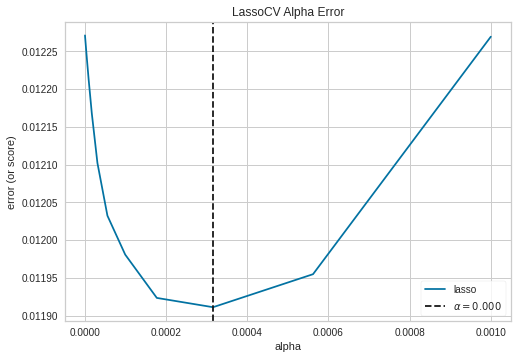

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [66]:
#%%time
# lasso, visualize with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_lasso])
X_tr = scaler.transform(X_train[predictors_lasso])

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-6, -3, 13)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=200000, cv=kfolds))
visualizer.fit(X_tr, y_train)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_lasso]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()


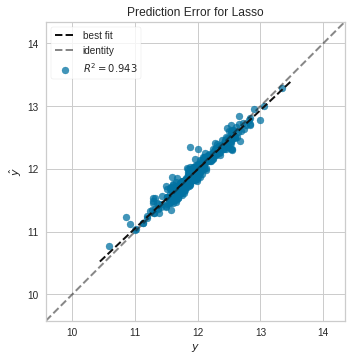

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [67]:
#%%time
visualizer = PredictionError(Lasso(alpha=alpha))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test[predictors_lasso]), y_test)
visualizer.poof()


In [68]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-6, -4, 9),
                              max_iter=100000,
                              cv=kfolds))

scores = np.sqrt(-cross_val_score(lasso, df[predictors_lasso], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

lasso.fit(X_train[predictors_lasso], y_train)

y_pred_train = lasso.predict(X_train[predictors_lasso])
y_pred_test = lasso.predict(X_test[predictors_lasso])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)


CV Score 0.1029 (STD 0.0112)

Train RMSE 17017.167629170355
Train R-squared 0.952734496792082
Train MAE 11554.516384305138

Test RMSE 16631.879410573994
Test R-squared 0.9454167022031763
Test MAE 11503.317692517694
alpha 0.0001
CPU times: user 5.47 s, sys: 34.9 s, total: 40.3 s
Wall time: 9.62 s


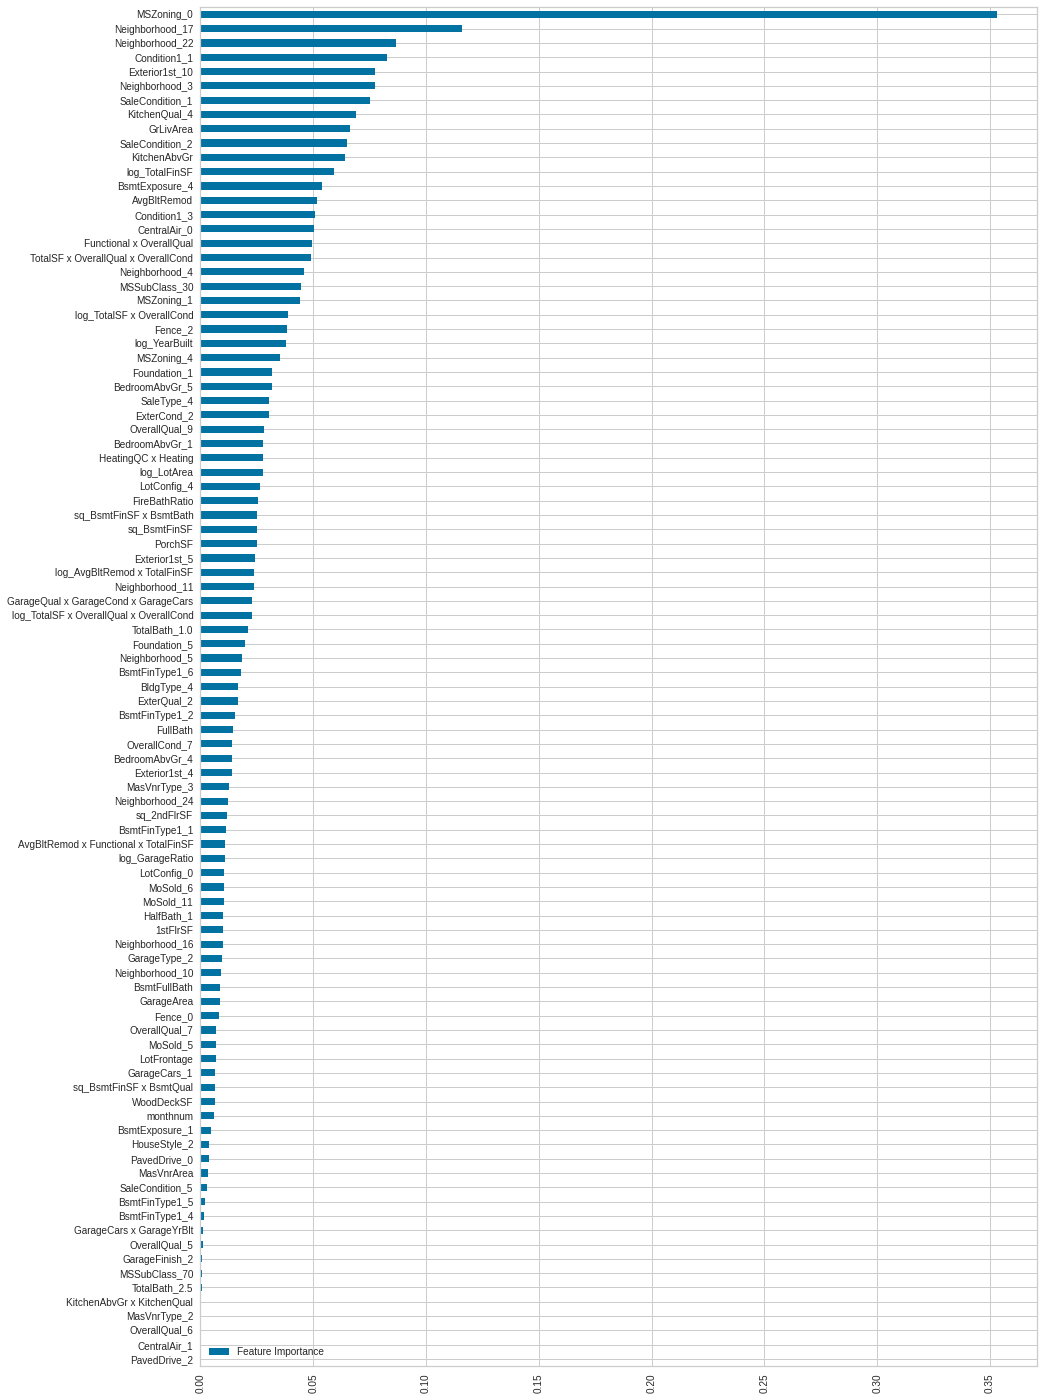

In [69]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors_lasso)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [70]:
# run this on all features to get lowimportlasso - determine features with 0 coefficients
list(imp_lasso.loc[imp_lasso['Feature Importance']==0].index)

['YearBuilt', 'GarageYrBlt', 'GarageFinish_3', 'MoSold_1', 'Neighborhood_19']

100
Train RMSE 17116.65745275679
Train R-squared 0.9521802115042224
Train MAE 11563.059668285925

Test RMSE 16448.887262512155
Test R-squared 0.9466111994071409
Test MAE 11346.871429189989
alpha 3.981071705534973


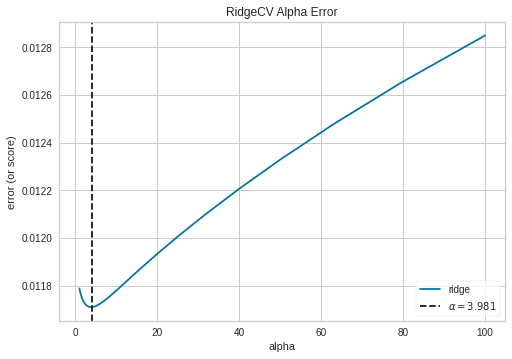

CPU times: user 887 ms, sys: 715 ms, total: 1.6 s
Wall time: 305 ms


<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [71]:
%%time
predictors_ridge = predictors_lasso 
print(len(predictors_ridge))
predictors_dict['ridge'] = predictors_ridge
    
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_ridge])
X_tr = scaler.transform(X_train[predictors_ridge])

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_ridge]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
visualizer.poof()

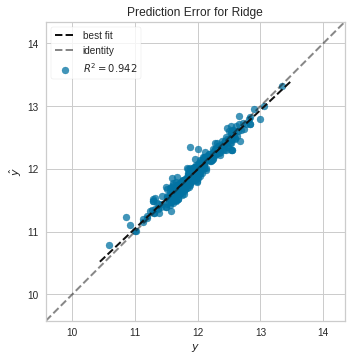

CPU times: user 410 ms, sys: 719 ms, total: 1.13 s
Wall time: 247 ms


<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [72]:
%%time
visualizer = PredictionError(Ridge(alpha=alpha))
visualizer.fit(X_train[predictors_ridge], y_train)
visualizer.score(X_test[predictors_ridge], y_test)
visualizer.poof()

In [73]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

scores = np.sqrt(-cross_val_score(ridge, df[predictors_ridge], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

ridge.fit(X_train[predictors_ridge], y_train)

y_pred_train = ridge.predict(X_train[predictors_ridge])
y_pred_test = ridge.predict(X_test[predictors_ridge])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)


CV Score 0.1034 (STD 0.0121)

Train RMSE 17116.657452758616
Train R-squared 0.9521802115042122
Train MAE 11563.059668286502

Test RMSE 16448.8872625071
Test R-squared 0.9466111994071738
Test MAE 11346.871429186955
alpha 3.981071705534973
CPU times: user 10min 58s, sys: 9min 51s, total: 20min 50s
Wall time: 4min 49s


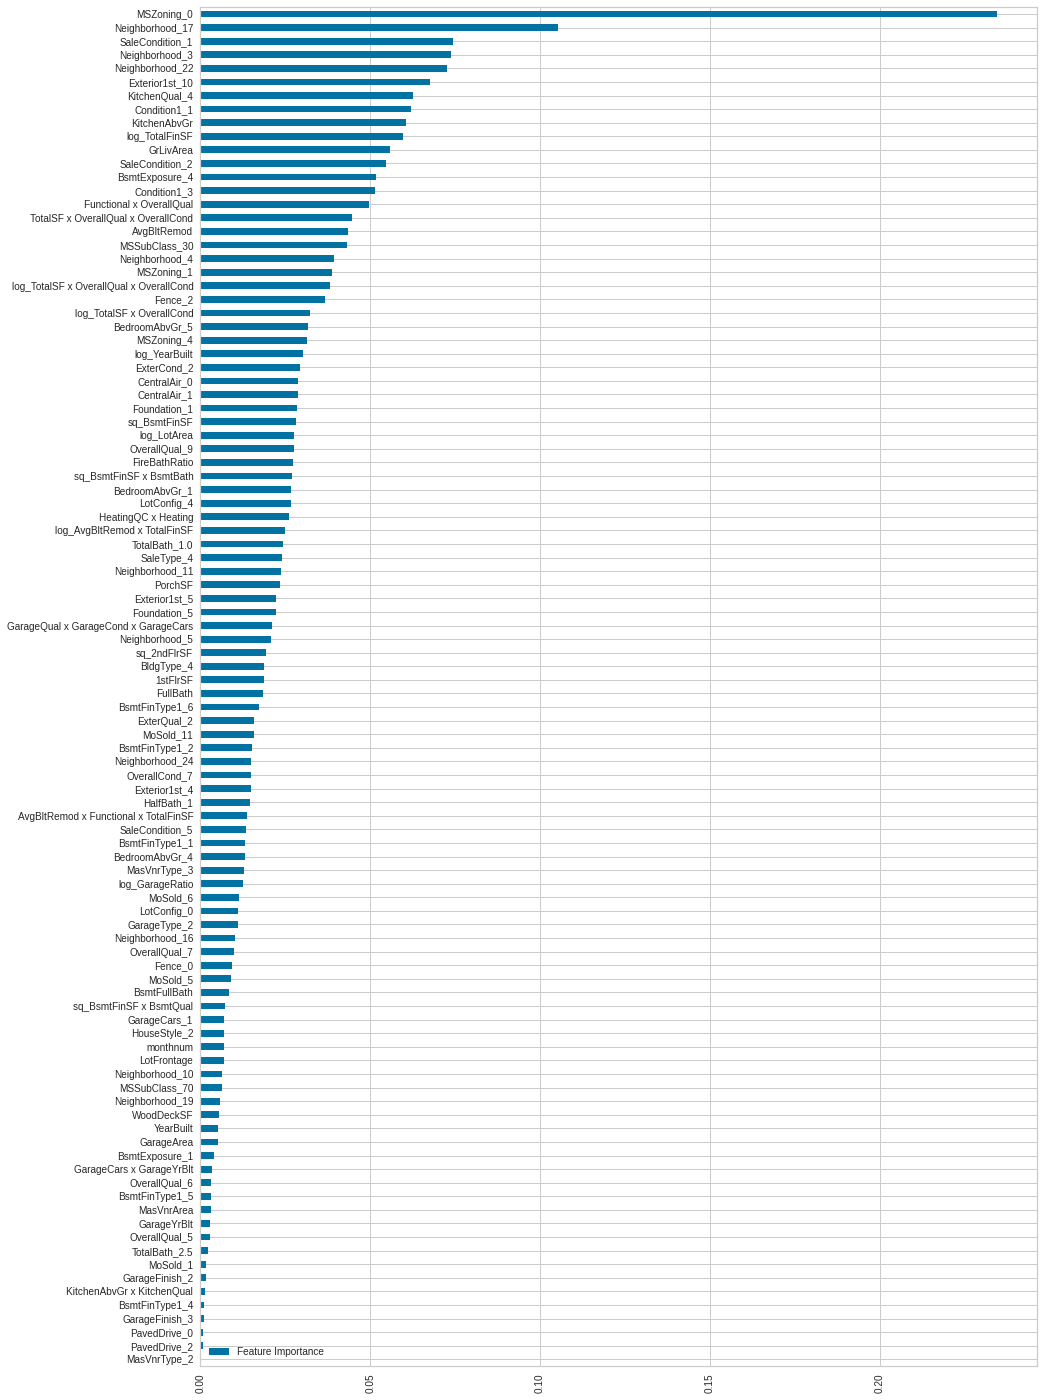

In [74]:
imp_ridge = pd.DataFrame({"Feature Importance" : ridge._final_estimator.coef_}, index=predictors_ridge)
imp_ridge["Feature Importance"]=abs(imp_ridge["Feature Importance"])
imp_ridge[imp_ridge["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [75]:
list(imp_ridge.loc[imp_ridge['Feature Importance']< 0.001].index)

['MasVnrType_2', 'PavedDrive_0', 'PavedDrive_2']

In [76]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

predictors_elastic = predictors_lasso
predictors_elastic = [p for p in predictors_elastic if p not in []]
print(len(predictors_elastic))
predictors_dict['elasticnet'] = predictors_elastic

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))

scores = np.sqrt(-cross_val_score(elasticnet, df[predictors_elastic], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))

print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

elasticnet.fit(X_train[predictors_elastic], y_train)

y_pred_train = elasticnet.predict(X_train[predictors_elastic])
y_pred_test = elasticnet.predict(X_test[predictors_elastic])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)


ElasticNetCV
100
CV Score 0.1028 (STD 0.0114)

Train RMSE 17107.735893777153
Train R-squared 0.9522300478558784
Train MAE 11541.32840316768

Test RMSE 16620.663029427284
Test R-squared 0.9454902982914078
Test MAE 11497.893990872935
l1_ratio 0.6
alpha 0.00039810717055349735
CPU times: user 54min 10s, sys: 48min 1s, total: 1h 42min 11s
Wall time: 34min 8s


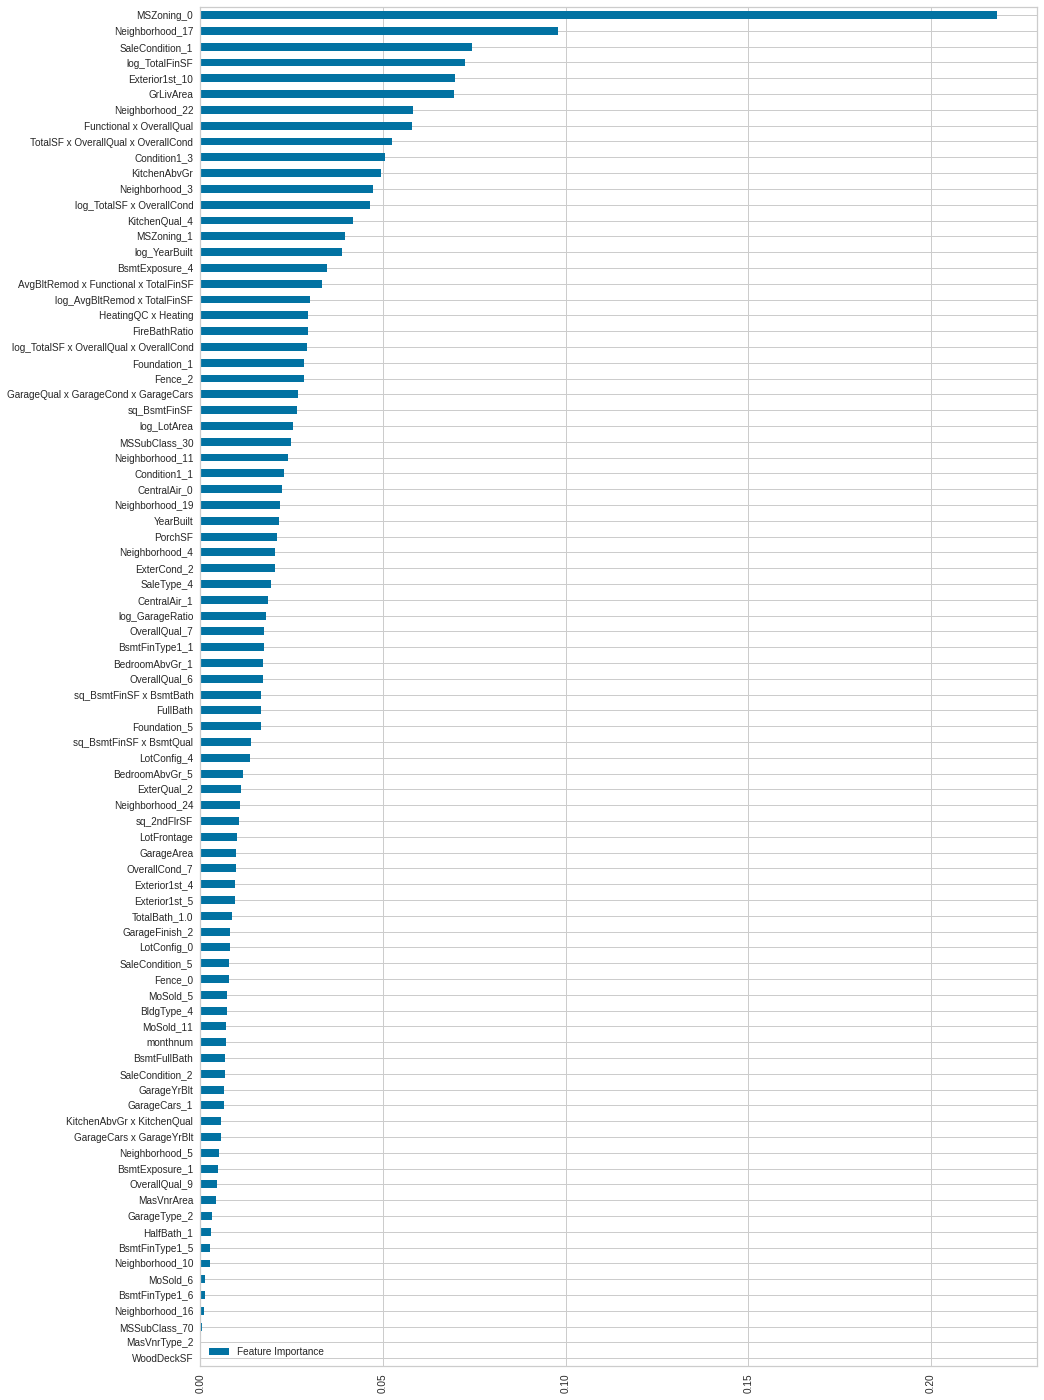

In [78]:
imp_elastic = pd.DataFrame({"Feature Importance" : elasticnet._final_estimator.coef_}, index=predictors_elastic)
imp_elastic["Feature Importance"]=abs(imp_elastic["Feature Importance"])
imp_elastic[imp_elastic["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)

plt.show()

In [79]:
sorted(list(imp_elastic.loc[imp_elastic['Feature Importance']< 0.001].index))

['1stFlrSF',
 'AvgBltRemod',
 'BedroomAbvGr_4',
 'BsmtFinType1_2',
 'BsmtFinType1_4',
 'GarageFinish_3',
 'HouseStyle_2',
 'MSSubClass_70',
 'MSZoning_4',
 'MasVnrType_2',
 'MasVnrType_3',
 'MoSold_1',
 'Neighborhood_16',
 'OverallQual_5',
 'PavedDrive_0',
 'PavedDrive_2',
 'TotalBath_2.5',
 'WoodDeckSF']

In [84]:
%%time
# tune KernelRidge
print("KernelRidge")

predictors_kr = predictors_lasso
predictors_kr = [p for p in predictors_kr if p not in []]
predictors_dict['kr'] = predictors_kr

kralphas = np.logspace(-5,0,11)
coef0s = np.linspace(1,10, 19)
krdegrees = [1,2,3]
 
gs = make_pipeline(use_transform(),
                   GridSearchCV(KernelRidge(kernel='poly'),
                                param_grid={'alpha': kralphas,
                                            'degree': krdegrees,
                                            'coef0': coef0s,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_kr], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)

# refit and evaluate
kralpha=gs._final_estimator.best_params_['alpha']
krdegree=gs._final_estimator.best_params_['degree']
coef0=gs._final_estimator.best_params_['coef0']
kr = make_pipeline(use_transform(),
                   KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                  )
print(kr)
scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

kr.fit(X_train[predictors_kr], y_train)

y_pred_train = kr.predict(X_train[predictors_kr])
y_pred_test = kr.predict(X_test[predictors_kr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

KernelRidge

CV on full dataset
Fitting 10 folds for each of 627 candidates, totalling 6270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 6270 out of 6270 | elapsed: 14.6min finished


best params {'alpha': 1.0, 'coef0': 10.0, 'degree': 2}
best score 0.008271136073691527
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kernelridge',
                 KernelRidge(alpha=1.0, coef0=10.0, degree=2, kernel='poly'))])
CV Score 0.0905 (STD 0.0082)

Train RMSE 15946.747312265235
Train R-squared 0.9584937060732728
Train MAE 10784.205310288802

Test RMSE 16251.735060725614
Test R-squared 0.947883338988921
Test MAE 11184.126406379455
CPU times: user 2min 42s, sys: 1min 16s, total: 3min 59s
Wall time: 15min 53s


In [93]:
kr

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kernelridge',
                 KernelRidge(alpha=1.0, coef0=10.0, degree=2, kernel='poly'))])

In [85]:
%%time
# tune SVR
print("SVR")

predictors_svr = predictors_lasso
predictors_svr = [p for p in predictors_svr if p not in []]
predictors_dict['svr'] = predictors_svr

svrdegrees = [3]
svrgammas = np.logspace(-4,-1,7)
Cs = np.logspace(1,2,5)
epsilons = np.logspace(-3,-1, 5)
coef0s = np.linspace(0,10, 6)


gs = make_pipeline(use_transform(),
                   GridSearchCV(SVR(kernel='rbf', 
                                    shrinking=True, 
                                    cache_size=200, 
                                    verbose=False, 
                                    max_iter=-1),
                                param_grid={'degree': svrdegrees,
                                            'gamma': svrgammas,
                                            'C': Cs,
                                            'epsilon': epsilons,
                                            'coef0': coef0s,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))
                                
print(gs)

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_svr], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)


SVR
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              estimator=SVR(), n_jobs=-1,
                              param_grid={'C': array([ 10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
       100.        ]),
                                          'coef0': array([ 0.,  2.,  4.,  6.,  8., 10.]),
                                          'degree': [3],
                                          'epsilon': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
                                          'gamma': array([0.0001    , 0.00031623, 0.001     , 0.00316228, 0.01      ,
       0.03162278, 0.1       ])},
                              scoring='neg_mean_squared_error', verbose=1))])

CV on full dataset
Fitting 10 folds for each of 1050 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 68.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 10500 out of 10500

best params {'C': 100.0, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.03162277660168379, 'gamma': 0.00031622776601683794}
best score 0.008324553992388285
CPU times: user 1min 11s, sys: 0 ns, total: 1min 11s
Wall time: 1h 26min 53s


In [86]:
# refit and evaluate
svrdegree=gs._final_estimator.best_params_['degree']
svrgamma=gs._final_estimator.best_params_['gamma']
svrC=gs._final_estimator.best_params_['C']
svrepsilon=gs._final_estimator.best_params_['epsilon']
svrcoef0=gs._final_estimator.best_params_['coef0']

svr = make_pipeline(use_transform(),
                    SVR(kernel='rbf', 
                         degree=svrdegree,
                         gamma=svrgamma,
                         C=svrC,
                         epsilon=svrepsilon,
                         coef0=svrcoef0,
                         shrinking=True, 
                         cache_size=200, 
                         verbose=False, 
                         max_iter=-1)
                   )
print(svr)
scores = np.sqrt(-cross_val_score(svr, df[predictors_svr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

svr.fit(X_train[predictors_svr], y_train)

y_pred_train = svr.predict(X_train[predictors_svr])
y_pred_test = svr.predict(X_test[predictors_svr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svr',
                 SVR(C=100.0, epsilon=0.03162277660168379,
                     gamma=0.00031622776601683794))])
CV Score 0.0909 (STD 0.0074)

Train RMSE 15832.510711992034
Train R-squared 0.9590862475494237
Train MAE 10019.974399010947

Test RMSE 16336.516404226031
Test R-squared 0.9473381608038896
Test MAE 10995.860366181943


In [87]:
%%time
# tune Gradient Boost
print("Gradient Boost")

predictors_gb=[p for p in predictors_lasso if p not in ['BsmtExposure_3',
                                                        'BsmtFinType2_3',
                                                        'Exterior1st_4',
                                                        'Exterior1st_5',
                                                        'Fence_2',
                                                        'LandSlope_1',
                                                        'MSZoning_0',
                                                        'MoSold_11',
                                                        'MoSold_5',
                                                        'MoSold_8',
                                                        'OverallQual_6',
                                                        'PavedDrive_2',
                                                        'SaleType_4',
                                                        'TotalBath_2.5',
                                                        'log_LowQualFinSF',
                                                       ]]
print(len(predictors_gb))
predictors_dict['gb'] = predictors_gb

gbestimatorss = [int(e) for e in np.logspace(3,4,3)]
gbestimatorss = [10000]
gbdepths = [2]
gblearnrates = np.logspace(-3,-1,5)
gblearnrates = [0.01]
gbsubsamples = [0.8]
gbmin_samples_leaf = [16]
gs = make_pipeline(use_transform(),
                   GridSearchCV(GradientBoostingRegressor(min_samples_leaf=16, 
                                                          loss='huber', 
                                                          max_features='sqrt',
                                                          random_state=RANDOM_STATE),
                                param_grid={'n_estimators': gbestimatorss,
                                            'max_depth': gbdepths,
                                            'subsample': gbsubsamples,
                                            'learning_rate': gblearnrates,
                                            'min_samples_leaf': gbmin_samples_leaf,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))
                                
print(gs)

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_gb], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)
                                                                                                         

Gradient Boost
90
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              estimator=GradientBoostingRegressor(loss='huber',
                                                                  max_features='sqrt',
                                                                  min_samples_leaf=16,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01],
                                          'max_depth': [2],
                                          'min_samples_leaf': [16],
                                          'n_estimators': [10000],
                                          'subsample': [0.8]},
                              scoring='neg_mean_squared_error', verbose=1))])

CV on full dataset
Fitting 10 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   52.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


best params {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 16, 'n_estimators': 10000, 'subsample': 0.8}
best score 0.009391149240635466
CPU times: user 35.1 s, sys: 0 ns, total: 35.1 s
Wall time: 2min 55s


In [88]:
# refit and evaluate
gb_n_estimators = gs._final_estimator.best_params_['n_estimators']
gb_max_depth = gs._final_estimator.best_params_['max_depth']
gb_subsample = gs._final_estimator.best_params_['subsample']
gb_learning_rate = gs._final_estimator.best_params_['learning_rate']
gb_min_samples_leaf = gs._final_estimator.best_params_['min_samples_leaf']
# technically no need to scale for gb
gb = GradientBoostingRegressor(n_estimators=gb_n_estimators,
                                             max_depth=gb_max_depth,
                                             subsample=gb_subsample,
                                             learning_rate=gb_learning_rate,
                                             min_samples_leaf=gb_min_samples_leaf, 
                                             loss='huber', 
                                             max_features='sqrt',
                                             random_state=RANDOM_STATE)
                  
print(gb)
scores = np.sqrt(-cross_val_score(gb, df[predictors_gb], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

gb.fit(X_train[predictors_gb], y_train)

y_pred_train = gb.predict(X_train[predictors_gb])
y_pred_test = gb.predict(X_test[predictors_gb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', min_samples_leaf=16,
                          n_estimators=10000, random_state=42, subsample=0.8)
CV Score 0.0966 (STD 0.0077)

Train RMSE 12022.948754016676
Train R-squared 0.9764065351725215
Train MAE 6931.158511877968

Test RMSE 18194.107606501177
Test R-squared 0.9346811343318528
Test MAE 11878.418817158461


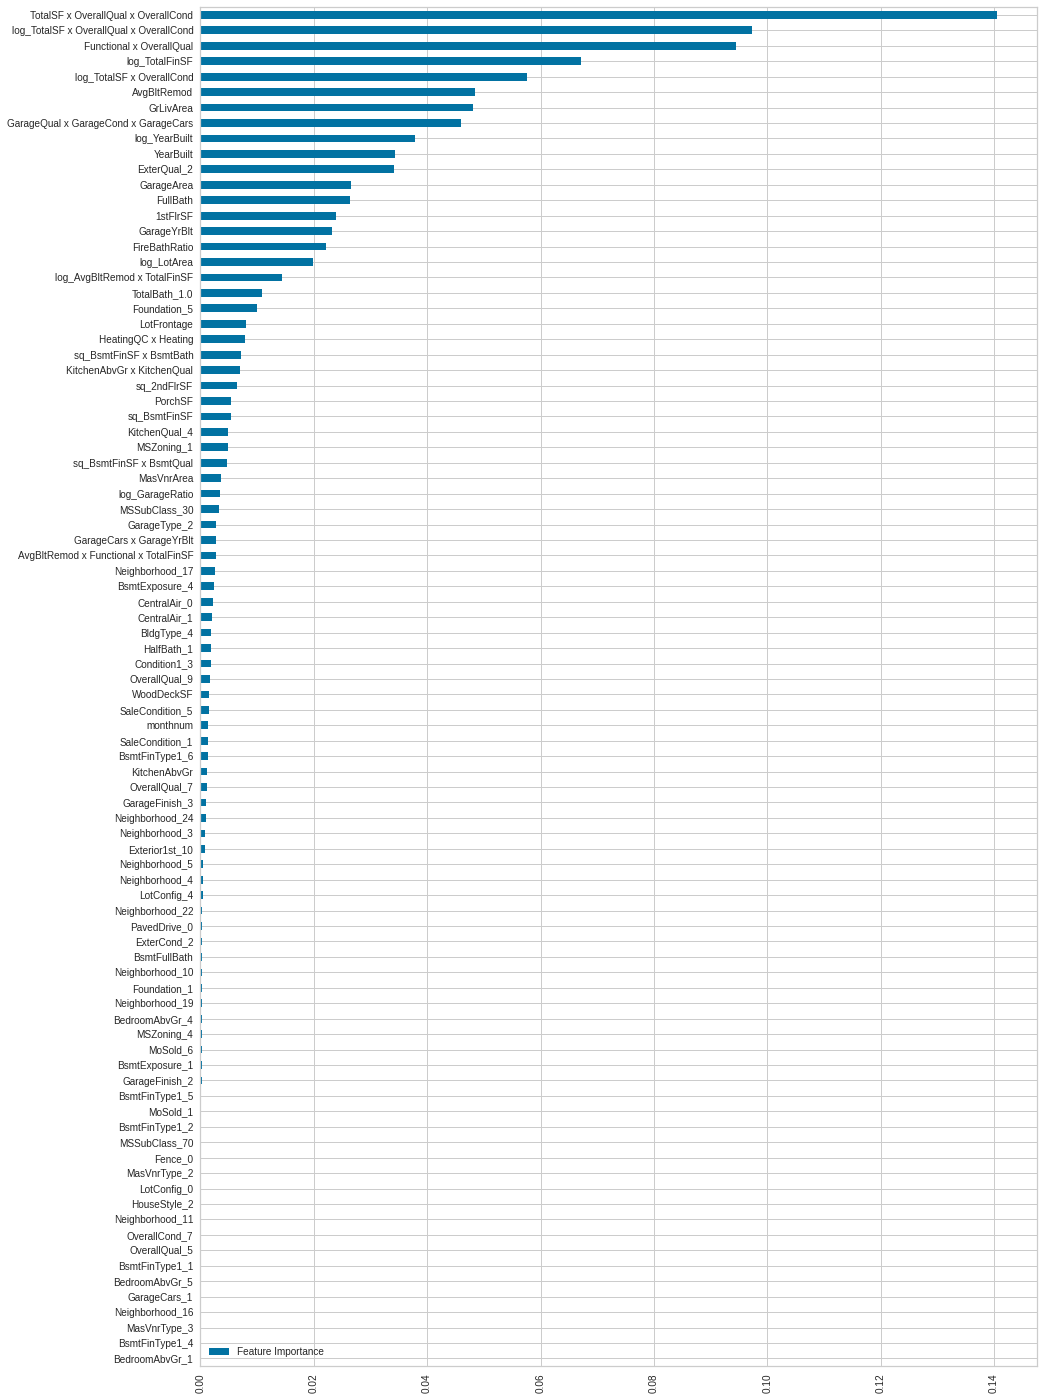

In [89]:
imp_gb = pd.DataFrame({"Feature Importance" : gb.feature_importances_}, index=predictors_gb)
imp_gb["Feature Importance"]=abs(imp_gb["Feature Importance"])
imp_gb[imp_gb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [90]:
sorted(list(imp_gb.loc[imp_gb['Feature Importance']<=0.0001].index))


['BedroomAbvGr_1',
 'BedroomAbvGr_5',
 'BsmtFinType1_1',
 'BsmtFinType1_4',
 'Condition1_1',
 'GarageCars_1',
 'MasVnrType_3',
 'Neighborhood_11',
 'Neighborhood_16',
 'OverallCond_7',
 'OverallQual_5',
 'SaleCondition_2']

In [91]:
# %%time
# tune XGBoost
print("XGBoost")
# XGboost - advanced decision tree model
# tune hyperparameters sequentially or in pairs
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
# https://xgboost.readthedocs.io/en/latest/parameter.html
predictors_xgb = predictors_lasso
predictors_dict['xgb'] = predictors_xgb
print(len(predictors_xgb))
#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
#n_estimators_xgb = 5623
n_estimators_xgb = 50000

#max_depth: max depth per base tree
max_depths = range(1,13)
max_depth = 1 #3

min_child_weights=np.linspace(0.0, 1.0, 6)
min_child_weight=0.0

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
# subsample = 0.55
subsample = 0.45 # 0.7

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15 # 0.25 

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-06  # 0.0001 # 

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.1, 0.05, 0.01, 0.005, 0.001]
learning_rate_xgb = 0.05  # 0.01


# n_estimators_xgb= 1336
# max_depth= 2
# subsample= 0.65
# colsample_bytree= 0.35
# reg_alpha= 1.63939e-05
# gamma= 0
# learning_rate_xgb= 0.05

eval_set=[(X_test[predictors_xgb], y_test.values.reshape(-1)),]
dtrain = xgboost.DMatrix(df[predictors_xgb], label=df[response])

for i in [1]:
        
        params = {
            'eval_metric': 'mae',
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'gamma': gamma,
            'learning_rate': learning_rate_xgb,
        }

        cv_results = xgboost.cv(
            params,
            dtrain,
            num_boost_round=50000,
            seed=RANDOM_STATE,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=100
        )
        
        print(params)
        display(cv_results[['test-mae-mean', 'test-mae-std']].sort_values('test-mae-mean').iloc[0])


XGBoost
100
{'eval_metric': 'mae', 'max_depth': 1, 'min_child_weight': 0.0, 'subsample': 0.45, 'colsample_bytree': 0.15, 'reg_alpha': 1e-06, 'gamma': 0, 'learning_rate': 0.05}


test-mae-mean    0.073669
test-mae-std     0.003720
Name: 2675, dtype: float64

In [88]:
# repeat on train-test split 
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=max_depth,
    n_estimators=50000,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate_xgb,
    min_child_weight=min_child_weight,
    reg_alpha=reg_alpha,
    n_jobs=-1)

display(xgb)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.15, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=1,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=50000, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=1e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.45, tree_method=None,
             validate_parameters=None, verbosity=None)

In [89]:
# determining rounds
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),
        eval_set=eval_set,
        eval_metric='rmse',
        early_stopping_rounds=100,
        verbose=True) #gives output log as below

scores = np.sqrt(-cross_val_score(xgb, df[predictors_xgb], df[response],
                              scoring="neg_mean_squared_error",
                              cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print(xgb.best_ntree_limit)


[0]	validation_0-rmse:10.93059
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.38334
[2]	validation_0-rmse:9.86574
[3]	validation_0-rmse:9.37256
[4]	validation_0-rmse:8.90407
[5]	validation_0-rmse:8.45954
[6]	validation_0-rmse:8.03756
[7]	validation_0-rmse:7.63784
[8]	validation_0-rmse:7.25533
[9]	validation_0-rmse:6.89248
[10]	validation_0-rmse:6.54958
[11]	validation_0-rmse:6.22234
[12]	validation_0-rmse:5.91190
[13]	validation_0-rmse:5.61618
[14]	validation_0-rmse:5.33628
[15]	validation_0-rmse:5.07115
[16]	validation_0-rmse:4.82029
[17]	validation_0-rmse:4.58110
[18]	validation_0-rmse:4.35303
[19]	validation_0-rmse:4.13605
[20]	validation_0-rmse:3.93045
[21]	validation_0-rmse:3.73531
[22]	validation_0-rmse:3.55015
[23]	validation_0-rmse:3.37450
[24]	validation_0-rmse:3.20694
[25]	validation_0-rmse:3.04817
[26]	validation_0-rmse:2.89676
[27]	validation_0-rmse:2.75309
[28]	validation_0-rmse:2.61681
[29]	validation_0-rmse:2.48763
[30]	validat

[258]	validation_0-rmse:0.12956
[259]	validation_0-rmse:0.12923
[260]	validation_0-rmse:0.12905
[261]	validation_0-rmse:0.12897
[262]	validation_0-rmse:0.12895
[263]	validation_0-rmse:0.12873
[264]	validation_0-rmse:0.12868
[265]	validation_0-rmse:0.12855
[266]	validation_0-rmse:0.12855
[267]	validation_0-rmse:0.12848
[268]	validation_0-rmse:0.12850
[269]	validation_0-rmse:0.12851
[270]	validation_0-rmse:0.12809
[271]	validation_0-rmse:0.12796
[272]	validation_0-rmse:0.12787
[273]	validation_0-rmse:0.12792
[274]	validation_0-rmse:0.12779
[275]	validation_0-rmse:0.12783
[276]	validation_0-rmse:0.12777
[277]	validation_0-rmse:0.12766
[278]	validation_0-rmse:0.12757
[279]	validation_0-rmse:0.12757
[280]	validation_0-rmse:0.12748
[281]	validation_0-rmse:0.12735
[282]	validation_0-rmse:0.12726
[283]	validation_0-rmse:0.12719
[284]	validation_0-rmse:0.12708
[285]	validation_0-rmse:0.12706
[286]	validation_0-rmse:0.12699
[287]	validation_0-rmse:0.12695
[288]	validation_0-rmse:0.12690
[289]	va

[515]	validation_0-rmse:0.11872
[516]	validation_0-rmse:0.11878
[517]	validation_0-rmse:0.11882
[518]	validation_0-rmse:0.11878
[519]	validation_0-rmse:0.11884
[520]	validation_0-rmse:0.11875
[521]	validation_0-rmse:0.11863
[522]	validation_0-rmse:0.11867
[523]	validation_0-rmse:0.11869
[524]	validation_0-rmse:0.11873
[525]	validation_0-rmse:0.11864
[526]	validation_0-rmse:0.11864
[527]	validation_0-rmse:0.11858
[528]	validation_0-rmse:0.11853
[529]	validation_0-rmse:0.11843
[530]	validation_0-rmse:0.11840
[531]	validation_0-rmse:0.11841
[532]	validation_0-rmse:0.11842
[533]	validation_0-rmse:0.11843
[534]	validation_0-rmse:0.11842
[535]	validation_0-rmse:0.11849
[536]	validation_0-rmse:0.11851
[537]	validation_0-rmse:0.11853
[538]	validation_0-rmse:0.11827
[539]	validation_0-rmse:0.11823
[540]	validation_0-rmse:0.11814
[541]	validation_0-rmse:0.11810
[542]	validation_0-rmse:0.11817
[543]	validation_0-rmse:0.11821
[544]	validation_0-rmse:0.11805
[545]	validation_0-rmse:0.11804
[546]	va

[772]	validation_0-rmse:0.11480
[773]	validation_0-rmse:0.11474
[774]	validation_0-rmse:0.11475
[775]	validation_0-rmse:0.11471
[776]	validation_0-rmse:0.11483
[777]	validation_0-rmse:0.11486
[778]	validation_0-rmse:0.11480
[779]	validation_0-rmse:0.11477
[780]	validation_0-rmse:0.11470
[781]	validation_0-rmse:0.11474
[782]	validation_0-rmse:0.11475
[783]	validation_0-rmse:0.11471
[784]	validation_0-rmse:0.11469
[785]	validation_0-rmse:0.11461
[786]	validation_0-rmse:0.11458
[787]	validation_0-rmse:0.11457
[788]	validation_0-rmse:0.11446
[789]	validation_0-rmse:0.11432
[790]	validation_0-rmse:0.11435
[791]	validation_0-rmse:0.11428
[792]	validation_0-rmse:0.11431
[793]	validation_0-rmse:0.11429
[794]	validation_0-rmse:0.11431
[795]	validation_0-rmse:0.11426
[796]	validation_0-rmse:0.11422
[797]	validation_0-rmse:0.11420
[798]	validation_0-rmse:0.11424
[799]	validation_0-rmse:0.11428
[800]	validation_0-rmse:0.11428
[801]	validation_0-rmse:0.11423
[802]	validation_0-rmse:0.11426
[803]	va

[1028]	validation_0-rmse:0.11251
[1029]	validation_0-rmse:0.11258
[1030]	validation_0-rmse:0.11263
[1031]	validation_0-rmse:0.11259
[1032]	validation_0-rmse:0.11256
[1033]	validation_0-rmse:0.11245
[1034]	validation_0-rmse:0.11246
[1035]	validation_0-rmse:0.11244
[1036]	validation_0-rmse:0.11249
[1037]	validation_0-rmse:0.11245
[1038]	validation_0-rmse:0.11244
[1039]	validation_0-rmse:0.11240
[1040]	validation_0-rmse:0.11245
[1041]	validation_0-rmse:0.11236
[1042]	validation_0-rmse:0.11237
[1043]	validation_0-rmse:0.11235
[1044]	validation_0-rmse:0.11235
[1045]	validation_0-rmse:0.11233
[1046]	validation_0-rmse:0.11232
[1047]	validation_0-rmse:0.11235
[1048]	validation_0-rmse:0.11232
[1049]	validation_0-rmse:0.11231
[1050]	validation_0-rmse:0.11223
[1051]	validation_0-rmse:0.11228
[1052]	validation_0-rmse:0.11222
[1053]	validation_0-rmse:0.11228
[1054]	validation_0-rmse:0.11226
[1055]	validation_0-rmse:0.11225
[1056]	validation_0-rmse:0.11218
[1057]	validation_0-rmse:0.11226
[1058]	val

[1277]	validation_0-rmse:0.11122
[1278]	validation_0-rmse:0.11124
[1279]	validation_0-rmse:0.11126
[1280]	validation_0-rmse:0.11121
[1281]	validation_0-rmse:0.11118
[1282]	validation_0-rmse:0.11113
[1283]	validation_0-rmse:0.11112
[1284]	validation_0-rmse:0.11115
[1285]	validation_0-rmse:0.11125
[1286]	validation_0-rmse:0.11131
[1287]	validation_0-rmse:0.11124
[1288]	validation_0-rmse:0.11129
[1289]	validation_0-rmse:0.11128
[1290]	validation_0-rmse:0.11128
[1291]	validation_0-rmse:0.11129
[1292]	validation_0-rmse:0.11126
[1293]	validation_0-rmse:0.11131
[1294]	validation_0-rmse:0.11130
[1295]	validation_0-rmse:0.11130
[1296]	validation_0-rmse:0.11126
[1297]	validation_0-rmse:0.11125
[1298]	validation_0-rmse:0.11127
[1299]	validation_0-rmse:0.11131
[1300]	validation_0-rmse:0.11135
[1301]	validation_0-rmse:0.11139
[1302]	validation_0-rmse:0.11138
[1303]	validation_0-rmse:0.11130
[1304]	validation_0-rmse:0.11125
[1305]	validation_0-rmse:0.11129
[1306]	validation_0-rmse:0.11134
[1307]	val

In [90]:
num_boost_round = xgb.best_ntree_limit+1
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=max_depth,
    n_estimators=num_boost_round,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate_xgb,
    min_child_weight=min_child_weight,
    reg_alpha=reg_alpha,
    n_jobs=-1)

display(xgb)
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),)

y_pred_train = xgb.predict(X_train[predictors_xgb])
y_pred_test = xgb.predict(X_test[predictors_xgb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.15, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=1,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=1285, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=1e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.45, tree_method=None,
             validate_parameters=None, verbosity=None)

Train RMSE 16137.858837951146
Train R-squared 0.9554426512270847
Train MAE 11287.856967576694

Test RMSE 21821.882105810386
Test R-squared 0.9200965825257542
Test MAE 13734.827051854401


In [92]:
# from hyperopt (not shown), better hyperparameters
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    n_estimators=1383,
    gamma=0,
    subsample=0.5,
    colsample_bytree=0.1,
    learning_rate=0.05,
    min_child_weight=0,
    reg_alpha=4.3667e-06,
    n_jobs=-1)

display(xgb)
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),)

y_pred_train = xgb.predict(X_train[predictors_xgb])
y_pred_test = xgb.predict(X_test[predictors_xgb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.1, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=1383, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=4.3667e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.5, tree_method=None,
             validate_parameters=None, verbosity=None)

Train RMSE 6239.800777594343
Train R-squared 0.9936450640196197
Train MAE 4597.499012706048

Test RMSE 19364.108760255935
Test R-squared 0.9260101507130957
Test MAE 12450.400540865383


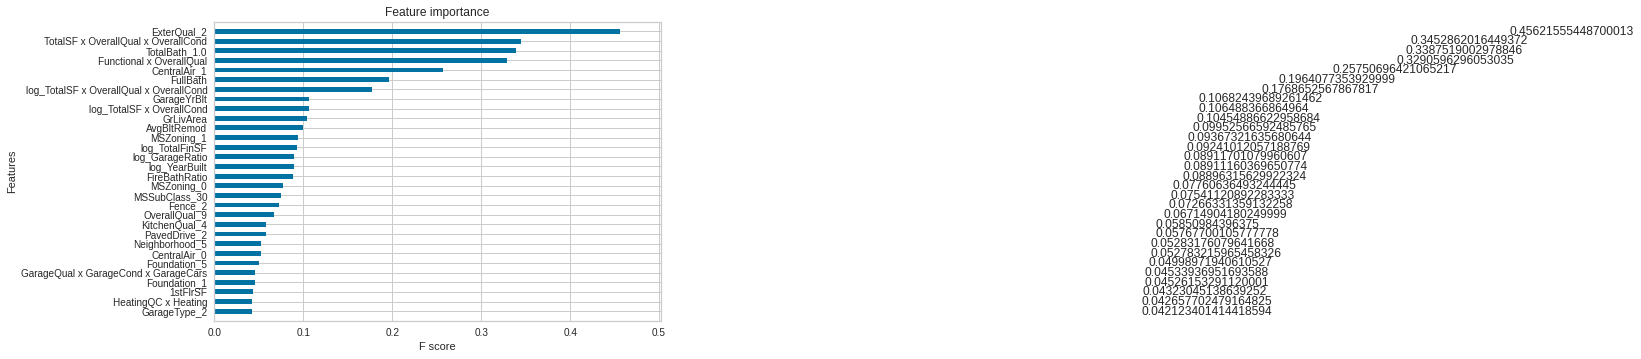

In [92]:
plot_importance(xgb, importance_type='gain', max_num_features=30, height=0.5);

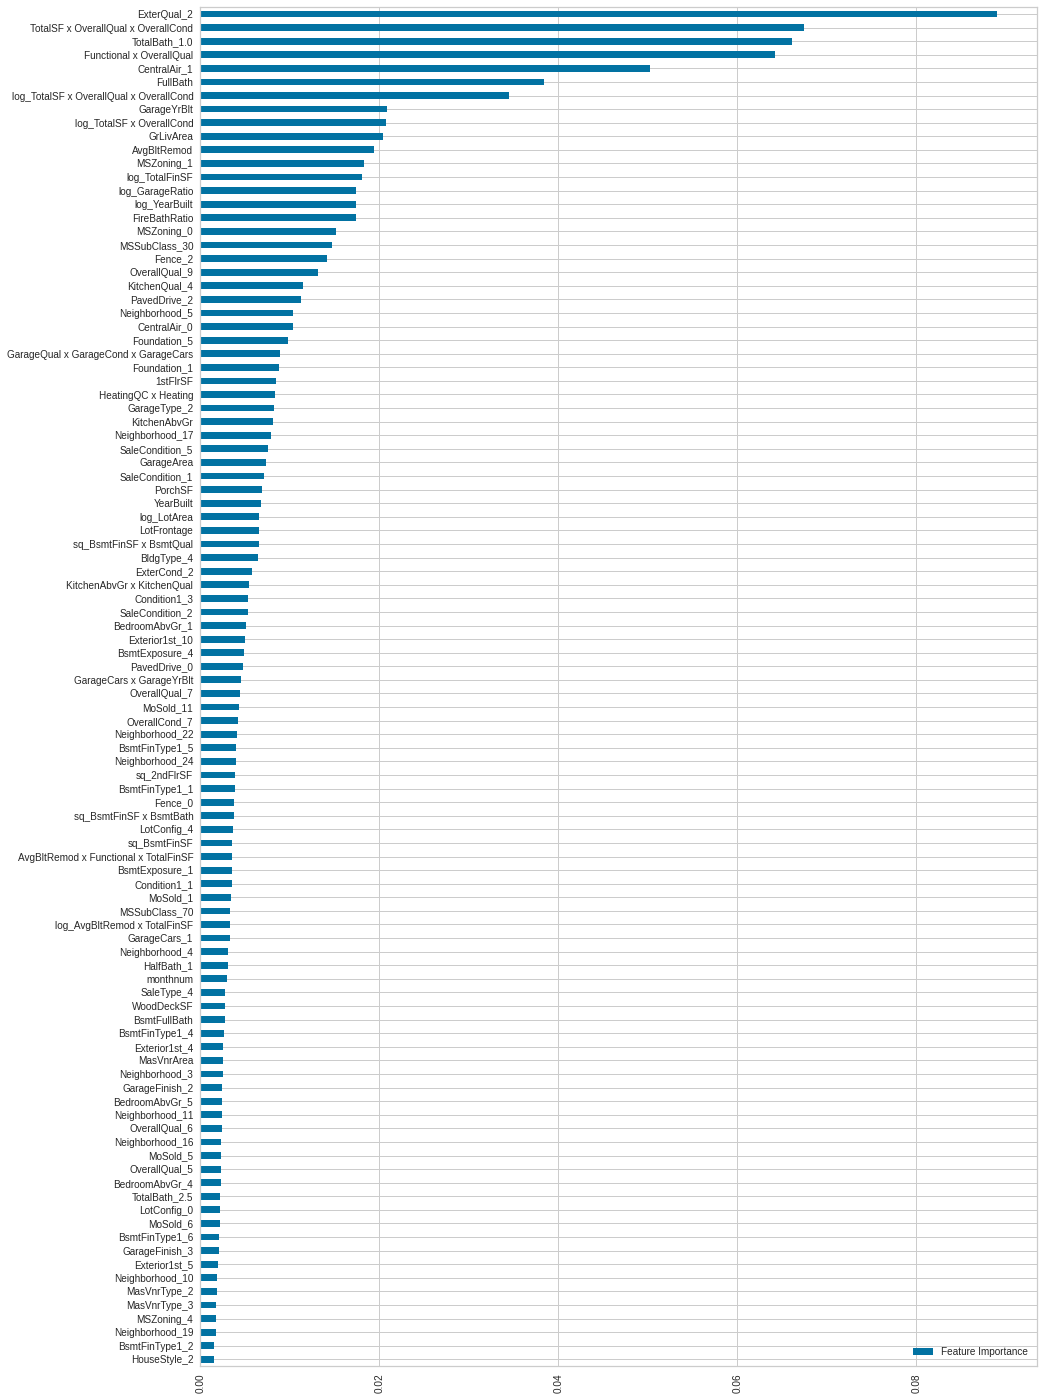

In [93]:
imp_xgb = pd.DataFrame({"Feature Importance" : xgb.feature_importances_}, index=predictors_xgb)
imp_xgb["Feature Importance"]=abs(imp_xgb["Feature Importance"])
imp_xgb[imp_xgb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [94]:
sorted(list(imp_xgb.loc[imp_xgb['Feature Importance']<0.0001].index))

[]

In [95]:
%%time
# get xgboost interactions, terms that show up in same prediction trees
# alternatives to find interactions:
#   generate many/all interactions (product, ratio, top 30 vs rest) and correlate vs. the residual
#   generate many/all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df[predictors_xgb]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


CPU times: user 4min 44s, sys: 27.6 ms, total: 4min 44s
Wall time: 4min 44s


(100, 100)

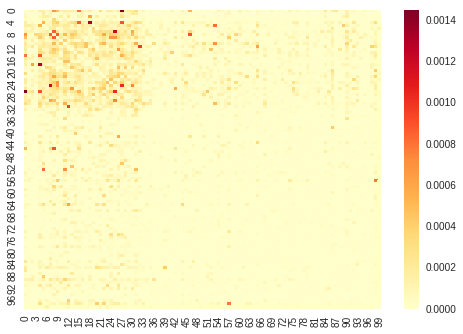

In [96]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [97]:
# print high interaction pairs
# last row, col = bias term
# could also sort, not print out symmetrical pairs
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002
interaction_list = []

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        # no dupes
        if j > i:
            continue
        if interaction_matrix[i,j] > threshold:
            interaction_list.append((predictors_xgb[i], predictors_xgb[j], interaction_matrix[i,j]))

for tup in sorted(interaction_list, key=lambda x: -x[2]):
    print(tup)
        

0.00040955783
('log_TotalSF x OverallCond', 'YearBuilt', 0.001449265)
('GarageCars x GarageYrBlt', 'GarageYrBlt', 0.0013046743)
('log_GarageRatio', '1stFlrSF', 0.0012093321)
('log_TotalSF x OverallCond', 'log_GarageRatio', 0.0010274104)
('sq_BsmtFinSF x BsmtBath', 'AvgBltRemod', 0.0009675522)
('log_TotalSF x OverallCond', 'GarageYrBlt', 0.0008995241)
('ExterQual_2', 'GrLivArea', 0.0008974277)
('GarageArea', 'GrLivArea', 0.0008702161)
('GrLivArea', '1stFlrSF', 0.0008619436)
('AvgBltRemod x Functional x TotalFinSF', 'GarageYrBlt', 0.000858742)
('Foundation_5', 'LotFrontage', 0.00081573083)
('AvgBltRemod x Functional x TotalFinSF', 'YearBuilt', 0.00079489325)
('TotalBath_1.0', 'GarageType_2', 0.0007826406)
('sq_BsmtFinSF', 'log_GarageRatio', 0.00074760633)
('Foundation_5', 'PorchSF', 0.0007152012)
('GrLivArea', 'YearBuilt', 0.0006827091)
('log_TotalFinSF', 'GarageArea', 0.0006771941)
('log_GarageRatio', 'GarageArea', 0.0006666725)
('log_TotalSF x OverallQual x OverallCond', 'FireBathRatio

In [95]:
%%time
# tune LightGBM
print("LightGBM")

predictors_lgbm = predictors_lasso
predictors_dict['lgbm'] = predictors_lgbm
print(len(predictors_lgbm))

#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         # early stopping params, maybe in fit
                         #early_stopping_rounds=early_stopping_rounds,
                         #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                         #num_boost_round=num_boost_round,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors_lgbm], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train[predictors_lgbm], y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train[predictors_lgbm])
y_pred_test = lgbm.predict(X_test[predictors_lgbm])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


LightGBM
100
5 5623 0.75 0.1
CV Score 0.0974 (STD 0.0085)

Train RMSE 8428.272349367162
Train R-squared 0.9884056380544566
Train MAE 6115.781678926474

Test RMSE 18437.96240633103
Test R-squared 0.9329184689098668
Test MAE 12252.93881146165
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s


In [96]:
# from hyperopt (not shown)
bagging_fraction=0.7548044328777966
feature_fraction=0.04994854048380451
learning_rate_lgbm=0.027701226718815856
n_estimators_lgbm=2758
num_leaves=5

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         # early stopping params, maybe in fit
                         #early_stopping_rounds=early_stopping_rounds,
                         #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                         #num_boost_round=num_boost_round,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors_lgbm], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train[predictors_lgbm], y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train[predictors_lgbm])
y_pred_test = lgbm.predict(X_test[predictors_lgbm])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


5 2758 0.7548044328777966 0.04994854048380451
CV Score 0.0979 (STD 0.0078)

Train RMSE 8187.304181117229
Train R-squared 0.9890591368981801
Train MAE 5910.384877517196

Test RMSE 18133.253934350916
Test R-squared 0.9351173464866686
Test MAE 11838.203191927432


NameError: name '_l' is not defined

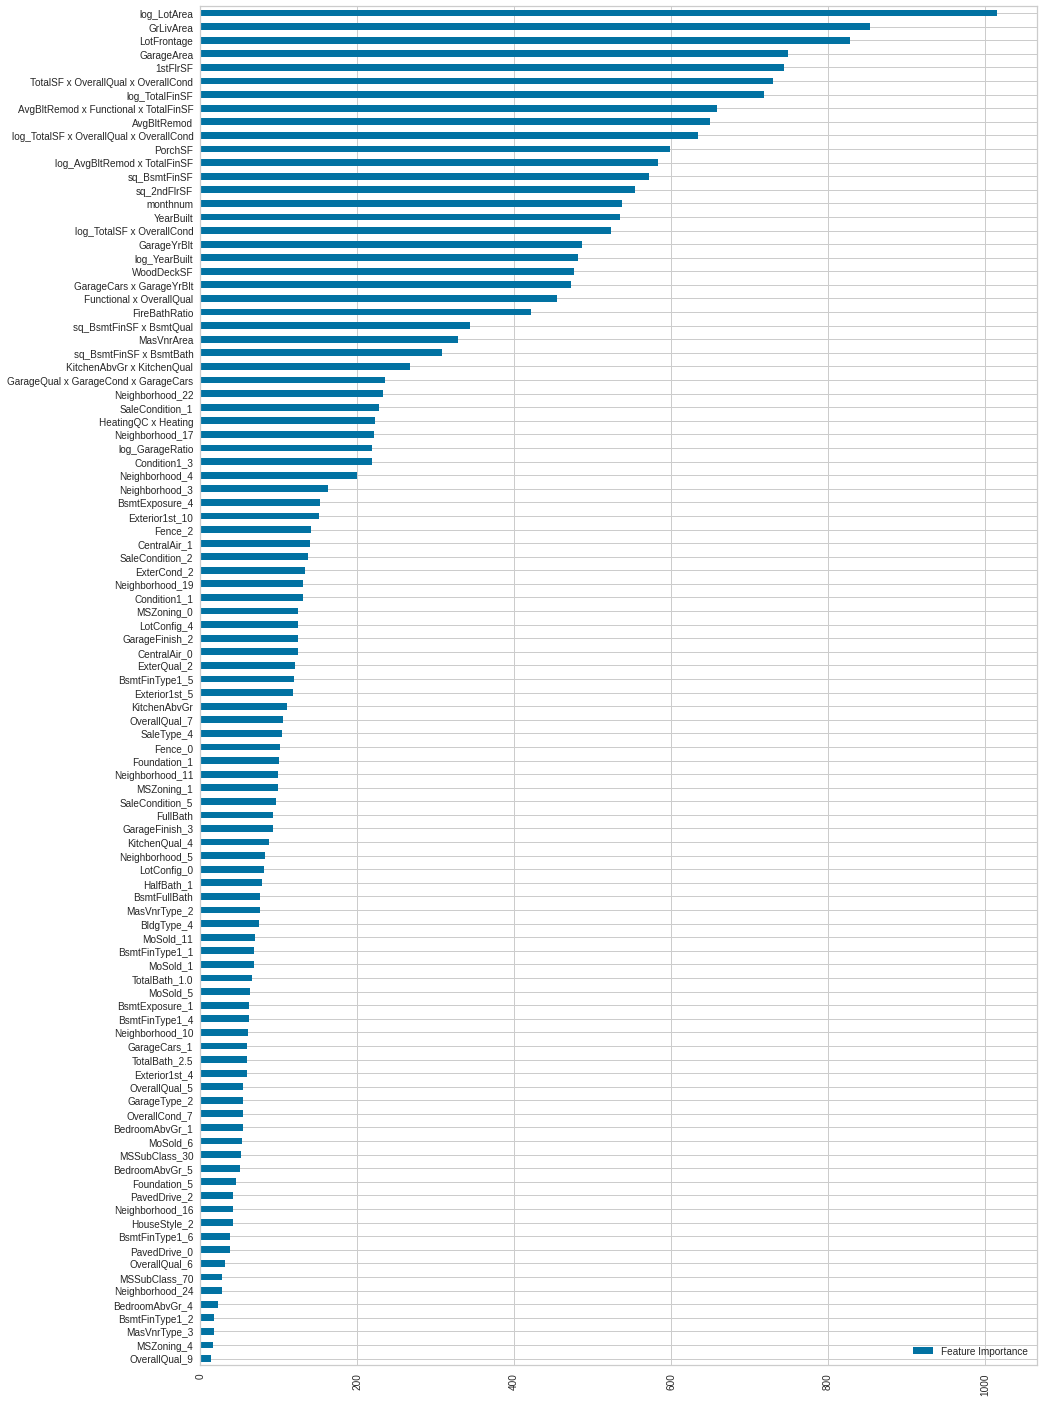

In [99]:
imp_lgbm = pd.DataFrame({"Feature Importance" : lgbm.feature_importances_}, index=predictors_lgbm)
imp_lgbm["Feature Importance"]=abs(imp_lgbm["Feature Importance"])
imp_lgbm[imp_lgbm["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [100]:
sorted(list(imp_lgbm.loc[imp_lgbm['Feature Importance']==0].index))

[]

In [77]:
%%time
# tune MLPRegressor
print("MLPregressor")

predictors_mlp = predictors_lasso
predictors_mlp = [p for p in predictors_mlp if p not in []]
predictors_dict['mlp'] = predictors_mlp
print(len(predictors_mlp))

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(0, 2, 3)
alphas = [10]
alpha = 10

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1]
nstartlayers = [16, 32, 64, 128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
#layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
# for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print(datetime.datetime.now(), "Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors_mlp], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train[predictors_mlp], y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train[predictors_mlp])
y_pred_test = mlp.predict(X_test[predictors_mlp])
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass


MLPregressor
100
2020-10-13 18:39:23.843859 Iteration 1: [128], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1049 (STD 0.0130)

Train RMSE 18203.204515328947
Train R-squared 0.9459164203123012
Train MAE 11982.213273088073

Test RMSE 16483.967265516145
Test R-squared 0.946383235488439
Test MAE 11564.482390280291
CPU times: user 58min 23s, sys: 57min 23s, total: 1h 55min 47s
Wall time: 35min 51s


<AxesSubplot:xlabel='nlayers', ylabel='nunits'>

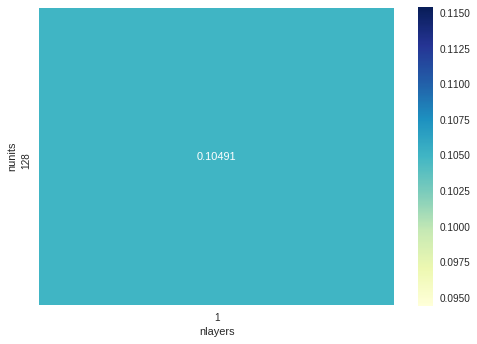

In [78]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [79]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission
# a lot of big misses on low values

#true_y	true_pred	error_stackblend	error_log
#968	135000.0	92484.266535	-42515.733465	-0.378233
#966	37900.0	59176.492175	21276.492175	0.445564
#495	34900.0	55705.837686	20805.837686	0.467587
#1320	147000.0	245498.611640	98498.611640	0.512856
#30	40000.0	70046.574544	30046.574544	0.560270
#462	62383.0	111468.357574	49085.357574	0.580441
#631	82500.0	152209.786746	69709.786746	0.612456

outliers = [968,966,495,1320,30,462,631]
df=df.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))


968     11.813037
966     10.542733
495     10.460271
1320    11.898195
30      10.596660
462     11.041064
631     11.320566
Name: SalePrice, dtype: float64
968     135000.0
966      37900.0
495      34900.0
1320    147000.0
30       40000.0
462      62383.0
631      82500.0
Name: SalePrice, dtype: float64


In [80]:
print(df.shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df.shape)
df.tail()


(1456, 425)
(1449, 425)


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,TotalFinSF,TotalSF,BsmtFinSF,PorchSF,TotalBath,BsmtBath,AvgBltRemod,PreWarYearBuilt,RecentYearBuilt,haspool,has2ndfloor,hasfireplace,LivAreaRatio,BedRatio,GarageRatio,BathRatio,LotRatio,FireBathRatio,TotalSF x OverallQual x OverallCond,TotalSF x OverallQual x Functional,AvgBltRemod x Functional x TotalFinSF,TotalSF x OverallQual,TotalSF x OverallCond,TotalFinSF x Functional,Functional x OverallQual,AvgBltRemod x OverallCond,AvgBltRemod x TotalFinSF,OverallCond x AvgBltRemod,BsmtFinSF x BsmtQual,BsmtFinSF x BsmtBath,KitchenAbvGr x KitchenQual,GarageCars x GarageYrBlt,GarageQual x GarageCond x GarageCars,HeatingQC x Heating,FireplaceQu x Fireplaces,monthnum,log_YearBuilt,log_GarageYrBlt,log_LotArea,log_LowQualFinSF,log_GrLivArea,log_WoodDeckSF,log_OpenPorchSF,log_EnclosedPorch,log_3SsnPorch,log_MiscVal,log_TotalFinSF,log_RecentYearBuilt,log_LivAreaRatio,log_BedRatio,log_GarageRatio,log_BathRatio,log_LotRatio,log_FireBathRatio,log_TotalSF x OverallQual x OverallCond,log_TotalSF x OverallQual,log_TotalSF x OverallCond,log_AvgBltRemod x OverallCond,log_AvgBltRemod x TotalFinSF,log_OverallCond x AvgBltRemod,sq_BsmtFinSF1,sq_BsmtFinSF2,sq_BsmtUnfSF,sq_2ndFlrSF,sq_BsmtFinSF,sq_PreWarYearBuilt,sq_Functional x OverallQual,sq_BsmtFinSF x BsmtQual,sq_BsmtFinSF x BsmtBath,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,CentralAir_0,CentralAir_1,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_4,Condition2_6,Electrical_0,Electrical_2,Electrical_3,Electrical_4,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,Exterior1st_0,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior2nd_1,Exterior2nd_2,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,Heating_1,Heating_2,Heating_4,Heating_5,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_4,LandSlope_0,Land

In [81]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [97]:
%%time

models = {
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'gb'        : gb,   
}

for i, m in enumerate(mlpmodels):
    mlpname = "mlp%d" % i
    predictors_dict[mlpname] = predictors_dict['mlp']
    models[mlpname] = m

for k, m in models.items():
    print(datetime.datetime.now(), k)
    
    use_predictors = predictors_dict.get(k)
    if use_predictors is None:
        print('fall back on full')
        use_predictors = predictors_full
        
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[use_predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[use_predictors], df[response])
    full_train_df[k] = m.predict(df[use_predictors])
    
    print()

2020-10-13 22:33:27.722891 lasso
CV Score 0.0920

2020-10-13 22:33:31.533278 ridge
CV Score 0.0921

2020-10-13 22:33:49.027665 elasticnet
CV Score 0.0921

2020-10-13 22:34:39.080657 kr
CV Score 0.0909

2020-10-13 22:34:40.090121 svr
CV Score 0.0912

2020-10-13 22:34:45.914995 xgb
CV Score 0.0988

2020-10-13 22:35:01.072929 lgbm
CV Score 0.0982

2020-10-13 22:35:07.026548 gb
CV Score 0.0969

2020-10-13 22:39:23.670572 mlp0
CV Score 0.0941

CPU times: user 18min 17s, sys: 0 ns, total: 18min 17s
Wall time: 6min 29s


In [100]:
xval_df

,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,boost_blend,linear_blend
0,12.247699,208500.0,12.246722,12.243314,12.246711,12.248109,12.258079,12.212517,12.211462,12.209422,12.236323,12.211989,12.246214
1,12.109016,181500.0,12.141684,12.138712,12.141841,12.128257,12.096266,12.139724,12.125866,12.137226,12.143713,12.132795,12.137624
2,12.317171,223500.0,12.279151,12.276830,12.278995,12.274908,12.278277,12.297468,12.261971,12.280501,12.277626,12.279719,12.277471
3,11.849405,140000.0,12.090120,12.078993,12.088266,12.062730,12.075966,12.009509,12.018296,12.053564,12.048837,12.013902,12.080027
4,12.429220,250000.0,12.562946,12.563892,12.562825,12.564114,12.556878,12.575129,12.590715,12.574900,12.558182,12.582922,12.563444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,12.072547,175000.0,12.068478,12.065702,12.069806,12.068583,12.084617,12.082981,12.099414,12.104021,12.064770,12.091198,12.068142
1445,12.254868,210000.0,12.294201,12.296405,12.294706,12.273159,12.268261,12.255397,12.269185,12.245803,12.299681,12.262291,12.289618
1446,12.493133,266500.0,12.477179,12.478318,12.476889,12.485489,12.487860,12.516374,12.528715,12.519025,12.456614,12.522544,12.479469
1447,11.864469,142125.0,11.876255,11.872225,11.876468,11.871849,11.875779,11.852282,11.888430,11.858684,11.870908,11.870356,11.874199


In [101]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0'],
#    'mlp_blend': ['mlp0', 'mlp1', 'mlp2', 'mlp3'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


boost_blend CV Score 0.0968
linear_blend CV Score 0.0915
mlp_blend CV Score 0.0941


### 6. Stack and Blend

In [102]:
#%%time
#concatenate raw predictors, blends, and stack with xgb
# something off about this , CV is worse than individual blends

df_stack_xval = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
df_stack_xval = pd.concat((df_stack_xval, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
df_stack_xval = use_transform().fit_transform(df_stack_xval)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1000

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    print(stack_xgb)
    
    scores = np.sqrt(-cross_val_score(stack_xgb, df_stack_xval, xval_df['log_y'],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print(np.mean(scores))
  
    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             df_stack_xval, 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    print("%s CV score %.04f" % ('stack_xgb', cvscores['stack_xgb']))
    
    stack_xgb.fit(df_stack_xval, 
                  xval_df['log_y'])
    
    df_stack_full = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
    df_stack_full = pd.concat((df_stack_full, full_train_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
    df_stack_full = use_transform().fit_transform(df_stack_full)
    
    full_train_df['stack_xgb'] = stack_xgb.predict(df_stack_xval)
    print("%s full train score %.04f" % ('stack_xgb', np.sqrt(mean_squared_error(full_train_df['log_y'], full_train_df['stack_xgb']))))


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.15, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=2,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=1e-05, reg_lambda=None,
             scale_pos_weight=None, subsample=0.4, tree_method=None,
             validate_parameters=None, verbosity=None)
0.0972831549623123
stack_xgb CV score 0.0976
stack_xgb full train score 0.0840


In [103]:
%%time
# this StackingCVRegressor stack is slow but offers improvement over stacking pre-calculated blends
# with use_features_in_secondary we probably need to scale 

#boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
#boost_blend.fit(df[predictors], df[response])

#linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
#                                           ('ridge', ridge), 
#                                           ('elasticnet', elasticnet), 
#                                           ('kr', kr)])
#linear_blend.fit(df[predictors], df[response])

#mlp_blend =    VotingRegressor(estimators=[('mlp%d' % i, mlpmodels[i]) for i in range(len(mlpmodels))])
#mlp_blend.fit(df[predictors], df[response])

stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[xgb, lgbm, 
                                                      lasso, ridge, elasticnet, kr,
                                                      svr, gb
                                                     ] + mlpmodels,
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors_lasso].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors_lasso].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors_lasso].values)
print(datetime.datetime.now(), "full train finished")


2020-10-14 00:10:36.979866 stack xval
2020-10-14 01:14:05.202804 xval finished
2020-10-14 01:14:05.203951 stack crossval score 0.093887
2020-10-14 01:14:05.204273 full train
2020-10-14 01:20:43.512784 full train finished
CPU times: user 2h 15min 12s, sys: 1h 3min 52s, total: 3h 19min 4s
Wall time: 1h 10min 6s


In [104]:
%%time
# stack again using a weighted average.
# 1st level stack does xval_predict using base models and features, meta prediction using base features+predictions
# 2nd level fit lasso model to the base models + stack
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendpredictors = ['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


2020-10-14 01:20:43.521110
stackblend crossval score 0.090243
stackblend full train score 0.072243
coefs {'stack': 0.0, 'stack_xgb': 0.0, 'boost_blend': 0.12276833797751308, 'gb': 0.1202238541434625, 'mlp_blend': 0.0, 'svr': 0.5156649844144306, 'linear_blend': 0.2539855248169501}
coefs adjusted to sum to 1 [0.         0.         0.12123559 0.11872288 0.         0.50922698
 0.25081455]
intercept -0.15358580329976412
sum 1.0126427013523562
alpha 1e-06
CPU times: user 196 ms, sys: 288 ms, total: 484 ms
Wall time: 62.6 ms


In [105]:
xval_df.head()

,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend
0,12.247699,208500.0,12.246722,12.243314,12.246711,12.248109,12.258079,12.212517,12.211462,12.209422,12.236323,12.211989,12.246214,12.236323,12.220119,12.222516,12.244947
1,12.109016,181500.0,12.141684,12.138712,12.141841,12.128257,12.096266,12.139724,12.125866,12.137226,12.143713,12.132795,12.137624,12.143713,12.135948,12.115602,12.115523
2,12.317171,223500.0,12.279151,12.276830,12.278995,12.274908,12.278277,12.297468,12.261971,12.280501,12.277626,12.279719,12.277471,12.277626,12.244528,12.262696,12.280161
3,11.849405,140000.0,12.090120,12.078993,12.088266,12.062730,12.075966,12.009509,12.018296,12.053564,12.048837,12.013902,12.080027,12.048837,12.054794,12.055758,12.065772
4,12.429220,250000.0,12.562946,12.563892,12.562825,12.564114,12.556878,12.575129,12.590715,12.574900,12.558182,12.582922,12.563444,12.558182,12.576176,12.560254,12.569077


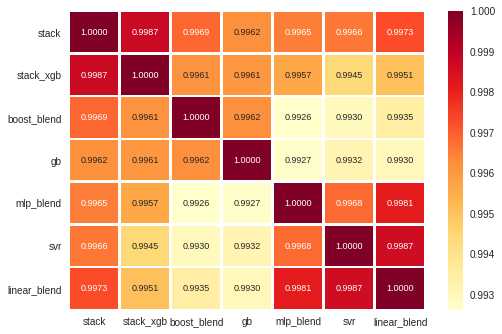

In [106]:
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


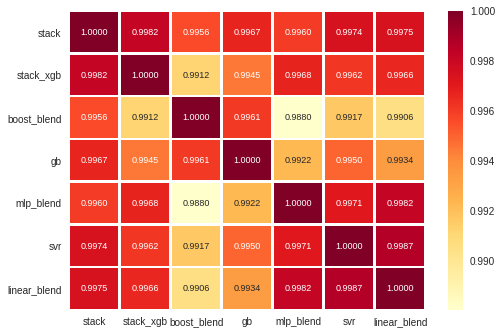

In [107]:
full_train_corr = full_train_df[['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [108]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


lasso
Train RMSE (log) 0.09198394975593674
Train RMSE 17501.058938607028
Train R-squared 0.9440446176950608
Train MAE 11734.527445511623
CV: 0.09198394975593674

ridge
Train RMSE (log) 0.09211332897770551
Train RMSE 17416.075518047266
Train R-squared 0.9445627136415183
Train MAE 11736.455744800687
CV: 0.09211332897770551

elasticnet
Train RMSE (log) 0.09205978303003992
Train RMSE 17556.165458929285
Train R-squared 0.9435248554891467
Train MAE 11764.935660626763
CV: 0.09205978303003992

kr
Train RMSE (log) 0.09091542648246559
Train RMSE 17210.875781943934
Train R-squared 0.9457305921079735
Train MAE 11575.003846301868
CV: 0.09091542648246559

svr
Train RMSE (log) 0.09122616286777124
Train RMSE 17211.91391580865
Train R-squared 0.944477087610934
Train MAE 11498.231727432552
CV: 0.09122616286777124

xgb
Train RMSE (log) 0.09881245992907606
Train RMSE 20139.997851098728
Train R-squared 0.9224456609414253
Train MAE 12841.531964393542
CV: 0.09881245992907606

lgbm
Train RMSE (log) 0.09819063

In [109]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend,error_log,true_pred,error_stackblend
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,12.026422,180649.077295,12.026422,12.026422,12.026422,12.026339,12.029952,12.026547,12.026422,12.028498,12.026420,12.026483,12.026402,12.026420,12.025833,12.026304,12.026955,0.000533,180257.776760,-391.300535
std,0.389836,76486.045908,0.379857,0.379631,0.379965,0.379683,0.375191,0.384364,0.382878,0.377691,0.375215,0.383482,0.379736,0.375215,0.377034,0.380130,0.381820,0.072266,75000.512512,13276.181756
min,10.471978,35311.000000,10.649273,10.633823,10.648740,10.584882,10.611083,10.509407,10.529053,10.869324,10.639826,10.519230,10.629180,10.639826,10.692017,10.675645,10.626032,-0.324851,41192.333563,-108727.432526
25%,11.775297,130000.000000,11.772317,11.769829,11.771980,11.773464,11.781246,11.781284,11.779735,11.784850,11.767239,11.780239,11.770881,11.767239,11.777057,11.784143,11.774322,-0.037597,129873.223071,-6273.461858
50%,12.004574,163500.000000,12.009329,12.006735,12.009632,12.004472,12.002208,11.998170,11.998252,11.998866,12.005425,12.000119,12.007611,12.005425,11.997867,12.000122,12.002253,-0.001261,163120.881508,-204.226885
75%,12.273736,214000.000000,12.273155,12.271599,12.273260,12.266029,12.269687,12.267518,12.261854,12.256334,12.266913,12.263249,12.272006,12.266913,12.256032,12.254489,12.268987,0.035159,212986.114363,5947.708048
max,13.345509,625000.000000,13.326123,13.331993,13.326232,13.333268,13.345596,13.335141,13.316620,13.319959,13.349769,13.325880,13.329404,13.349769,13.184805,13.194963,13.351119,0.418192,628516.562471,71081.785873


<AxesSubplot:xlabel='error_log'>

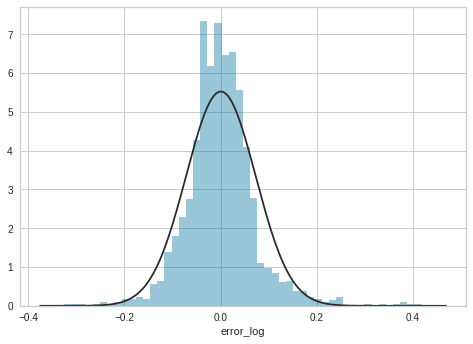

In [110]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


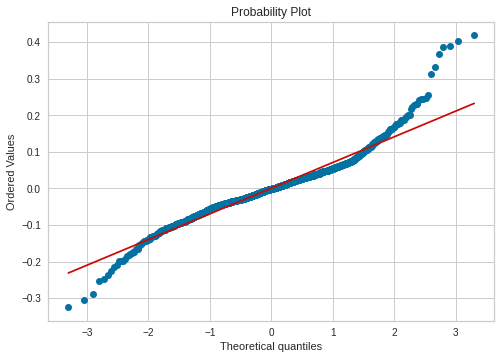

In [111]:
res = stats.probplot(residual['error_log'], plot=plt);

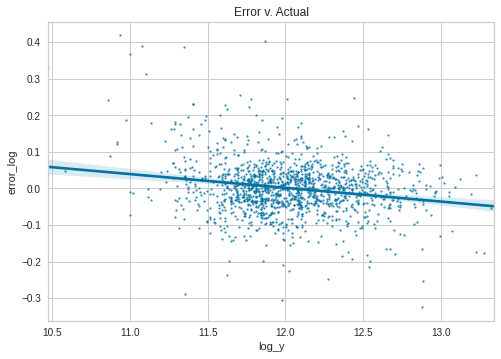

In [112]:
sns.regplot(x="log_y", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Actual');


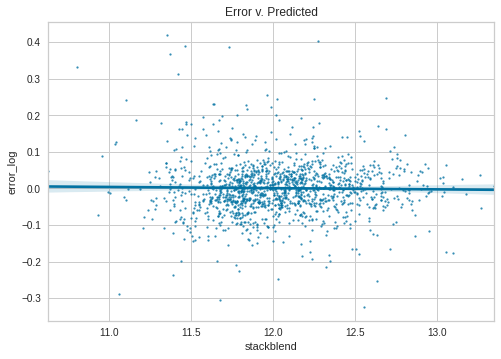

In [113]:
sns.regplot(x="stackblend", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Predicted');

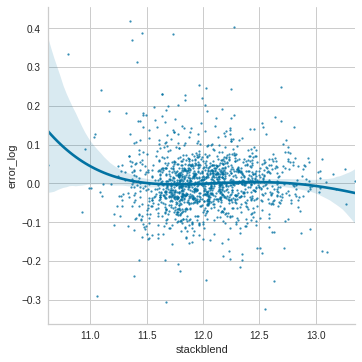

In [114]:
sns.lmplot(x="stackblend", y="error_log", data=residual,
           order=4, scatter_kws={"s": 5});

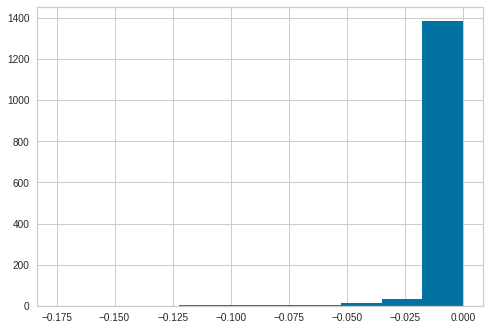

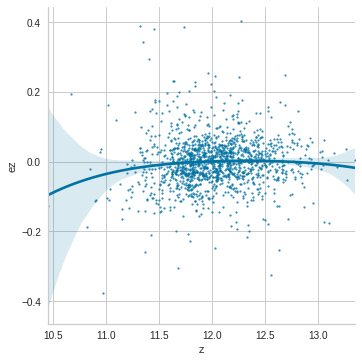

In [115]:
# maybe worth making a kludgy adjustment 
# there might be a more systematic way of forcing toward a prior distribution
full_train_df['bias_adjustment'] = (full_train_df['stackblend'] - 11.5) * 0.2
full_train_df['bias_adjustment'] = full_train_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
full_train_df['bias_adjustment'].hist()
residual['z'] = full_train_df['stackblend'] + full_train_df['bias_adjustment']
residual['ez'] = residual['z'] - residual['log_y']

sns.lmplot(x="z", y="ez", data=residual,
           order=4, scatter_kws={"s": 5});

In [116]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


,true_y,true_pred,error_stackblend,error_log
683,392000.0,283272.567474,-108727.432526,-0.324851
676,159434.0,117398.974902,-42035.025098,-0.306050
87,85000.0,63631.361728,-21368.638272,-0.289541
768,395000.0,306925.089934,-88074.910066,-0.252281
327,214500.0,167344.441913,-47155.558087,-0.248254
...,...,...,...,...
409,60000.0,86724.994335,26724.994335,0.368392
1442,84500.0,124313.095891,39813.095891,0.386048
1421,64500.0,95117.589911,30617.589911,0.388444
584,143000.0,213913.816382,70913.816382,0.402726


### 7. Run on test set, export CSV for submission

In [117]:
# raw models

submit_df = pd.DataFrame({'xgb'       : xgb.predict(df_test[predictors_xgb]), 
                          'lgbm'      : lgbm.predict(df_test[predictors_lgbm]),
                          'gb'        : gb.predict(df_test[predictors_gb]),
                          'svr'       : svr.predict(df_test[predictors_svr]),
                          'lasso'     : lasso.predict(df_test[predictors_lasso]),
                          'ridge'     : ridge.predict(df_test[predictors_ridge]),
                          'elasticnet': elasticnet.predict(df_test[predictors_elastic]),
                          'kr'        : kr.predict(df_test[predictors_kr]),
                          'stack'     : stack.predict(df_test[predictors_lasso])
                         })
for i, m in enumerate(mlpmodels):
    submit_df["mlp%d" % i] = m.predict(df_test[predictors_mlp])

#blends

for blend, components in blends.items():
    submit_df[blend] = np.mean(submit_df[components], axis=1)

# fix ids to line up with test
submit_df.reset_index(inplace=True)
submit_df.rename(columns={'index': 'Id'}, inplace=True)
submit_df['Id']+=1461
submit_df.set_index('Id', inplace=True)
                    
# create stack dataset

submit_stack = pd.DataFrame(df_test[predictors_lasso],
                            columns=predictors_lasso)
submit_stack = pd.concat((submit_stack, submit_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
submit_stack = use_transform().fit_transform(submit_stack)
submit_df['stack_xgb'] = stack_xgb.predict(submit_stack)

# blend prediction
submit_df['stackblend']=blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.0 * submit_df['stack'] + \
     0.0        * submit_df['stack_xgb'] + \
     0.17401562  * submit_df['boost_blend'] + \
     0.15988875 * submit_df['gb']  + \
     0.0        * submit_df['mlp_blend'] + \
     0.37571465 * submit_df['svr'] + \
     0.29038099 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.10       * submit_df['stack'] + \
     0.15       * submit_df['boost_blend'] + \
     0.15       * submit_df['gb'] + \
     0.10       * submit_df['mlp_blend'] +\
     0.15       * submit_df['svr'] + \
     0.35       * submit_df['linear_blend'] 

submit_df.head()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3
Id,,,,,,,,,,,,,,,,,
1461,11.778484,11.730140,11.721716,11.681036,11.665521,11.664468,11.665255,11.673115,11.691289,11.674625,11.754312,11.667090,11.674625,11.732256,11.685475,11.696242,11.693632
1462,11.973364,11.962117,11.968477,11.951744,11.942503,11.944382,11.942192,11.945599,11.963512,11.958851,11.967741,11.943669,11.958851,11.979014,11.951185,11.954858,11.955715
1463,12.157813,12.106298,12.138864,12.136563,12.128332,12.126087,12.128010,12.129383,12.125956,12.124372,12.132055,12.127953,12.124372,12.162251,12.133953,12.133647,12.130939
1464,12.221041,12.195408,12.202555,12.193627,12.196219,12.195310,12.196230,12.192610,12.189713,12.196902,12.208224,12.195092,12.196902,12.221059,12.197439,12.198020,12.197605
1465,12.103213,12.115605,12.134399,12.141695,12.164854,12.157976,12.165304,12.144974,12.129398,12.107837,12.109409,12.158277,12.107837,12.165007,12.140984,12.139725,12.136946


<AxesSubplot:>

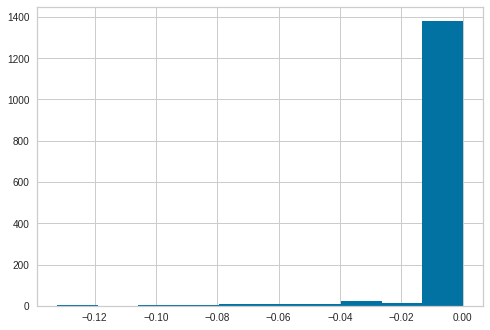

In [118]:
submit_df['bias_adjustment'] = (submit_df['stackblend'] - 11.5) * 0.2
submit_df['bias_adjustment'] = submit_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
submit_df['stackblend_adjust'] = submit_df['stackblend'] + submit_df['bias_adjustment']
submit_df['stackblend3_adjust'] = submit_df['stackblend3'] + submit_df['bias_adjustment']
submit_df['bias_adjustment'].hist()

In [119]:
submit_df =np.expm1(submit_df)
submit_df.describe()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3,bias_adjustment,stackblend_adjust,stackblend3_adjust
count,1459.000000,1459.000000,1459.000000,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1.459000e+03,1459.000000,1.459000e+03,1.459000e+03,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,179268.695668,179495.246554,179134.217868,179345.309430,1.804166e+05,1.804624e+05,1.804206e+05,1.799823e+05,179318.247094,1.805318e+05,179349.850463,1.803140e+05,1.805318e+05,184539.274141,179455.754386,179398.273658,179549.628307,-0.002879,179250.062813,179342.218917
std,78815.936276,79388.917768,77792.683326,77561.342555,9.138310e+04,9.133533e+04,9.131590e+04,8.746772e+04,78848.005165,9.697658e+04,78992.632980,9.029225e+04,9.697658e+04,79098.702483,79425.895344,78623.601456,80284.087728,0.013384,79704.181856,80560.511630
min,48488.407304,48648.841397,55774.987677,50912.347860,4.595569e+04,4.881716e+04,4.585363e+04,4.950908e+04,48979.435220,5.011059e+04,48568.558108,4.751453e+04,5.011059e+04,53596.996508,50956.663366,51323.244392,51387.170675,-0.123878,44644.130645,45021.307575
25%,127434.261256,128730.560650,129012.255547,127754.349780,1.265754e+05,1.264445e+05,1.265451e+05,1.270503e+05,128569.083177,1.269302e+05,128287.496139,1.265759e+05,1.269302e+05,132649.750970,126547.913150,127456.564362,127734.796847,0.000000,126547.913150,127734.796847
50%,158959.475062,157241.288278,157792.999497,158417.912281,1.579748e+05,1.575836e+05,1.581277e+05,1.575986e+05,156718.602499,1.584608e+05,158769.044505,1.576278e+05,1.584608e+05,162476.348412,157602.029022,158085.146832,157551.064928,0.000000,157602.029022,157551.064928
75%,210596.557305,210331.747190,209581.649439,209238.995719,2.106567e+05,2.103716e+05,2.105565e+05,2.093723e+05,209290.533702,2.105722e+05,210749.825719,2.105662e+05,2.105722e+05,214710.491420,209678.082523,209563.594349,209660.285323,0.000000,209678.082523,209660.285323
max,642728.893816,707640.335075,665023.142308,568095.891997,1.926364e+06,1.924738e+06,1.918344e+06,1.686462e+06,520519.868016,2.380796e+06,674404.100925,1.861030e+06,2.380796e+06,522362.808627,565987.957382,639358.862706,920478.160393,0.000000,565987.957382,920478.160393


In [120]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['boost_blend']}).to_csv('boost_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['linear_blend']}).to_csv('linear_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['mlp_blend']}).to_csv('mlp_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['svr']}).to_csv('svr.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['gb']}).to_csv('gb.csv', index=False)

pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack']}).to_csv('stack.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack_xgb']}).to_csv('stack_xgb.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend_adjust']}).to_csv('stackblend_adjust.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3_adjust']}).to_csv('stackblend3_adjust.csv', index=False)

print(datetime.datetime.now())


2020-10-14 01:20:49.264085


 ### Concluding remarks
 - At time of writing 05/2019 there are 2 Kaggle contests using this data set
     - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard
     - https://www.kaggle.com/c/home-data-for-ml-course/leaderboard
 - 1st contest is tougher leaderboard, this solution is about .115 log error,  top 250 / 4500, 
 - Maybe top 5% after accounting for blenders, people who posted others' top kernels, peeked at test set solutions LOL
     - looking at people who posted top kernels, some of them blend with other people's results
     - and data is publicly available so it's possible to look up solutions for the test set
 - 2nd contest (InClass) is softer leaderboard, this solution came in about 12500 raw error, rank top 100 / 5000, top 2%
 - Observing that other people blended, I blended output from this with 3 other top kernels:
    - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
    - https://www.kaggle.com/couyang/hybrid-svm-benchmark-approach-0-11180-lb-top-2
    - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - Blend achieved #156 and #3 on 2 leaderboards 0.110, 12100
 - Seems pointless to blend but was curious how high I could go
 - Could maybe improve raw model a little further
     - A very careful visual or systematic examination of which predictors should be dummified, transformed
     - Systematic elimination of non-helpful predictors
     - Add additional models, for averaging, stacking
 - Pretty curious how top results were achieved, quite a few in .1106 range, brute force, more clever features, or just better blending top kernels?
 